In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost openpyxl tensorflow keras -q

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


In [3]:
# Load the dataset
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')

# Convert date columns
date_columns = ['sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['actual_expedition_date'].min()} to {df['actual_expedition_date'].max()}")
df.head()

Dataset shape: (15297, 25)

Date range: 2023-01-04 15:37:01 to 2025-09-16 00:00:00


,expedition_number,client_order_number,product_name,client_name,postal_code_client,city_client,country_client,sales_order_creation_date,promised_expedition_date,actual_expedition_date,date_and_time_expedition,contract_number,\ntotal_ordered_converted,total_amount_ordered_tm,total_amount_delivered_tm,city_of_delivery,inventory_tag,inventory_location,total_ordered_converted,purchasing_order_number,trucking_company_name,bill_number,cost_of_purchased_order,quantity_of_purchase_order,year
0,231352.0,SO-11118,Huile de Soya,MEUNERIE MARIO BERARD INC,J0E 1E0,ANGE-GARDIEN,canada,2023-01-03,2023-01-03,2023-01-04 15:37:01,NaT,NaN,NaN,3.00,2.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,231353.0,SO-11119,Trituro Laitier - Régulier,FERME QUIKO INC,J0J 1Y0,SAINT-IGNACE-DE-STANBRIDGE,canada,2023-01-03,2023-01-05,2023-01-05 09:16:47,NaT,NaN,NaN,5.00,5.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
2,231356.0,SO-11120,Trituro Laitier - Régulier,LES MOULEES BELLIFRANCE,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-03,2023-01-06,2023-01-05 14:01:47,NaT,NaN,NaN,3.10,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3,231354.0,SO-11120,Trituro Laitier - Régulier,LES MOULEES BELLIFRANCE,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-03,2023-01-06,2023-01-06 12:03:53,NaT,NaN,NaN,4.62,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
4,231355.0,SO-11121,Trituro Laitier - Régulier,SOLLIO AGRICULTURE S.E.C.,G6E 0L9,Sainte-Marie,canada,2023-01-03,2023-01-05,2023-01-05 07:39:39,NaT,NaN,NaN,3.15,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


In [4]:
# Create order size categories
df['order_size_category'] = pd.cut(
    df['total_amount_delivered_tm'],
    bins=[0, 5, 10, 20, np.inf],
    labels=['Small', 'Medium', 'Large', 'Extra Large'],
    include_lowest=True
)

print("Order Size Distribution:")
print(df['order_size_category'].value_counts())
print(f"\nPercentage:")
print(df['order_size_category'].value_counts(normalize=True) * 100)

Order Size Distribution:
order_size_category
Extra Large    7294
Small          3673
Medium         2714
Large          1616
Name: count, dtype: int64

Percentage:
order_size_category
Extra Large    47.682552
Small          24.011244
Medium         17.742041
Large          10.564163
Name: proportion, dtype: float64


In [5]:
# Filter for Small and Medium orders only
df_filtered = df[df['order_size_category'].isin(['Small', 'Medium'])].copy()

print(f"Original dataset: {len(df)} records")
print(f"Filtered dataset (Small + Medium): {len(df_filtered)} records")
print(f"\nCategory breakdown:")
print(df_filtered['order_size_category'].value_counts())

Original dataset: 15297 records
Filtered dataset (Small + Medium): 6387 records

Category breakdown:
order_size_category
Small          3673
Medium         2714
Large             0
Extra Large       0
Name: count, dtype: int64


In [6]:
# Ensure unique SO numbers by deduplicating client_order_number
print(f"Before deduplication: {len(df_filtered)} records")
print(f"Unique client_order_numbers: {df_filtered['client_order_number'].nunique()}")

# Check for duplicates
duplicates = df_filtered['client_order_number'].duplicated().sum()
print(f"Duplicate SO numbers found: {duplicates}")

# Keep only the first occurrence of each client_order_number
# (assuming first record is the most accurate)
df_filtered = df_filtered.drop_duplicates(subset='client_order_number', keep='first')

print(f"After deduplication: {len(df_filtered)} records")
print()

# Sort by client and date
df_filtered = df_filtered.sort_values(['client_name', 'actual_expedition_date'])

# Calculate days since last order for each client
df_filtered['days_since_last_order'] = df_filtered.groupby('client_name')['actual_expedition_date'].diff().dt.days

# Create next order date (target variable)
df_filtered['next_order_date'] = df_filtered.groupby('client_name')['actual_expedition_date'].shift(-1)
df_filtered['days_until_next_order'] = (df_filtered['next_order_date'] - df_filtered['actual_expedition_date']).dt.days

print("Days until next order - Statistics:")
print(df_filtered['days_until_next_order'].describe())



Before deduplication: 6387 records
Unique client_order_numbers: 3734
Duplicate SO numbers found: 2653
After deduplication: 3734 records

Days until next order - Statistics:
count    3537.000000
mean       23.114221
std        47.551775
min         0.000000
25%         2.000000
50%         8.000000
75%        26.000000
max       662.000000
Name: days_until_next_order, dtype: float64


In [7]:
# Client-level features
client_features = df_filtered.groupby('client_name').agg({
    'total_amount_delivered_tm': ['mean', 'std', 'min', 'max', 'count'],
    'days_since_last_order': ['mean', 'std', 'median'],
    'actual_expedition_date': ['min', 'max']
}).reset_index()

client_features.columns = ['_'.join(col).strip('_') for col in client_features.columns.values]
client_features.rename(columns={'client_name': 'client_name'}, inplace=True)

# Calculate client lifetime (days active)
client_features['client_lifetime_days'] = (
    client_features['actual_expedition_date_max'] - client_features['actual_expedition_date_min']
).dt.days

# Calculate order frequency (orders per month)
client_features['order_frequency_per_month'] = (
    client_features['total_amount_delivered_tm_count'] / 
    (client_features['client_lifetime_days'] / 30)
)

print("Client Features Created:")
print(client_features.head())

Client Features Created:
                             client_name  total_amount_delivered_tm_mean  \
0    9252-8405 Quebec INC (FERME TRUDEL)                        5.030000   
1  9377-8454 QUÉBEC INC/ LASHOP AGRICOLE                        1.000000   
2                        AGRI ST-LAURENT                        3.916000   
3                        AGRI-MARCHE INC                        4.093091   
4                  AGRI-SERVICE DMR Inc.                        3.923000   

   total_amount_delivered_tm_std  total_amount_delivered_tm_min  \
0                       0.063770                           4.97   
1                            NaN                           1.00   
2                       1.108989                           2.25   
3                       1.666587                           1.38   
4                       0.843630                           2.42   

   total_amount_delivered_tm_max  total_amount_delivered_tm_count  \
0                           5.09              

In [8]:
# Order-level features
df_features = df_filtered.copy()

# Time-based features
df_features['order_month'] = df_features['actual_expedition_date'].dt.month
df_features['order_quarter'] = df_features['actual_expedition_date'].dt.quarter
df_features['order_day_of_week'] = df_features['actual_expedition_date'].dt.dayofweek
df_features['order_day_of_month'] = df_features['actual_expedition_date'].dt.day
df_features['is_weekend'] = df_features['order_day_of_week'].isin([5, 6]).astype(int)

# Client order sequence
df_features['order_sequence'] = df_features.groupby('client_name').cumcount() + 1

# Recency, Frequency, Monetary (RFM) features
current_date = df_features['actual_expedition_date'].max()
df_features['recency_days'] = (current_date - df_features['actual_expedition_date']).dt.days

# Product-based features
df_features['product_encoded'] = LabelEncoder().fit_transform(df_features['product_name'].fillna('Unknown'))

# Rolling window features (last 3 orders per client)
df_features['rolling_avg_quantity_3'] = df_features.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
df_features['rolling_std_quantity_3'] = df_features.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.rolling(window=3, min_periods=1).std()
).fillna(0)

print(f"\nFeature engineering complete. Total features: {df_features.shape[1]}")
print("\nSample features:")
print(df_features[['client_name', 'order_sequence', 'order_month', 'rolling_avg_quantity_3', 'days_until_next_order']].head(10))


Feature engineering complete. Total features: 39

Sample features:
                                 client_name  order_sequence  order_month  \
11555    9252-8405 Quebec INC (FERME TRUDEL)               1           11   
13681    9252-8405 Quebec INC (FERME TRUDEL)               2            2   
14666    9252-8405 Quebec INC (FERME TRUDEL)               3            6   
15270    9252-8405 Quebec INC (FERME TRUDEL)               4            9   
2669   9377-8454 QUÉBEC INC/ LASHOP AGRICOLE               1            8   
185                          AGRI ST-LAURENT               1            1   
319                          AGRI ST-LAURENT               2            2   
394                          AGRI ST-LAURENT               3            2   
454                          AGRI ST-LAURENT               4            3   
491                          AGRI ST-LAURENT               5            3   

       rolling_avg_quantity_3  days_until_next_order  
11555                4.980000

In [9]:
# Merge client-level features
df_features = df_features.merge(client_features, on='client_name', how='left')

print(f"Dataset shape after merging: {df_features.shape}")
print(f"\nColumns: {df_features.columns.tolist()}")

Dataset shape after merging: (3734, 51)

Columns: ['expedition_number', 'client_order_number', 'product_name', 'client_name', 'postal_code_client', 'city_client', 'country_client', 'sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition', 'contract_number', '\ntotal_ordered_converted', 'total_amount_ordered_tm', 'total_amount_delivered_tm', 'city_of_delivery', 'inventory_tag', 'inventory_location', 'total_ordered_converted', 'purchasing_order_number', 'trucking_company_name', 'bill_number', 'cost_of_purchased_order', 'quantity_of_purchase_order', 'year', 'order_size_category', 'days_since_last_order', 'next_order_date', 'days_until_next_order', 'order_month', 'order_quarter', 'order_day_of_week', 'order_day_of_month', 'is_weekend', 'order_sequence', 'recency_days', 'product_encoded', 'rolling_avg_quantity_3', 'rolling_std_quantity_3', 'total_amount_delivered_tm_mean', 'total_amount_delivered_tm_std', 'total_amount_delivered_tm_min', 

In [10]:
# Remove rows where we don't have a next order (last order for each client)
df_model = df_features[df_features['days_until_next_order'].notna()].copy()

# Remove outliers (optional - orders with extremely long reorder times)
# Keep reorder times within reasonable range (e.g., < 365 days)
df_model = df_model[df_model['days_until_next_order'] <= 365]

print(f"Modeling dataset size: {len(df_model)} records")
print(f"Target variable (days_until_next_order) statistics:")
print(df_model['days_until_next_order'].describe())

Modeling dataset size: 3524 records
Target variable (days_until_next_order) statistics:
count    3524.000000
mean       21.379115
std        37.486807
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max       363.000000
Name: days_until_next_order, dtype: float64


In [11]:
# Select features for modeling
feature_columns = [
    # Order-level features
    'total_amount_delivered_tm',
    'order_sequence',
    'order_month',
    'order_quarter',
    'order_day_of_week',
    'is_weekend',
    'days_since_last_order',
    'product_encoded',
    'rolling_avg_quantity_3',
    'rolling_std_quantity_3',
    
    # Client-level features
    'total_amount_delivered_tm_mean',
    'total_amount_delivered_tm_std',
    'total_amount_delivered_tm_count',
    'days_since_last_order_mean',
    'days_since_last_order_std',
    'client_lifetime_days',
    'order_frequency_per_month'
]

# Create X and y
X = df_model[feature_columns].fillna(0)
y = df_model['days_until_next_order']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {feature_columns}")

Features shape: (3524, 17)
Target shape: (3524,)

Features used: ['total_amount_delivered_tm', 'order_sequence', 'order_month', 'order_quarter', 'order_day_of_week', 'is_weekend', 'days_since_last_order', 'product_encoded', 'rolling_avg_quantity_3', 'rolling_std_quantity_3', 'total_amount_delivered_tm_mean', 'total_amount_delivered_tm_std', 'total_amount_delivered_tm_count', 'days_since_last_order_mean', 'days_since_last_order_std', 'client_lifetime_days', 'order_frequency_per_month']


In [12]:
# Analyze reorder time patterns
print("="*80)
print("REORDER TIME DISTRIBUTION ANALYSIS")
print("="*80)

# Calculate statistics
same_day = (df_model['days_until_next_order'] == 0).sum()
next_day = (df_model['days_until_next_order'] == 1).sum()
within_week = (df_model['days_until_next_order'] <= 7).sum()
long_term = (df_model['days_until_next_order'] > 30).sum()

total = len(df_model)

print(f"\nTotal orders analyzed: {total:,}")
print(f"\nReorder time breakdown:")
print(f"  Same day (0 days):     {same_day:,} orders ({same_day/total*100:.1f}%)")
print(f"  Next day (1 day):      {next_day:,} orders ({next_day/total*100:.1f}%)")
print(f"  Within week (≤7 days): {within_week:,} orders ({within_week/total*100:.1f}%)")
print(f"  Long term (>30 days):  {long_term:,} orders ({long_term/total*100:.1f}%)")



REORDER TIME DISTRIBUTION ANALYSIS

Total orders analyzed: 3,524

Reorder time breakdown:
  Same day (0 days):     573 orders (16.3%)
  Next day (1 day):      225 orders (6.4%)
  Within week (≤7 days): 1,719 orders (48.8%)
  Long term (>30 days):  683 orders (19.4%)


In [13]:
# Analyze same-day reorders by client
same_day_clients = df_model[df_model['days_until_next_order'] == 0].groupby('client_name').size()
same_day_clients = same_day_clients.sort_values(ascending=False)

print(f"\n{'='*80}")
print("SAME-DAY REORDER ANALYSIS (Top 10 Clients)")
print(f"{'='*80}")
print(f"Note: These may be middlemen ordering multiple times for different end clients")
print(f"\nTop 10 clients with most same-day reorders:")
for idx, (client, count) in enumerate(same_day_clients.head(10).items(), 1):
    total_orders = len(df_model[df_model['client_name'] == client])
    print(f"  {idx}. {client[:45]:45s} - {count:3d} same-day reorders ({count/total_orders*100:.0f}% of their orders)")




SAME-DAY REORDER ANALYSIS (Top 10 Clients)
Note: These may be middlemen ordering multiple times for different end clients

Top 10 clients with most same-day reorders:
  1. SOLLIO AGRICULTURE S.E.C.                     - 129 same-day reorders (42% of their orders)
  2. LES ENTREPRISES LAFRANCE DIVISON GRAIN INC    - 125 same-day reorders (36% of their orders)
  3. COVRIS COOPERATIF                             -  83 same-day reorders (56% of their orders)
  4. SOLLIO GROUPE COOPÉRATIF                      -  52 same-day reorders (37% of their orders)
  5. ELEVAGES J. BERTRAND INC                      -  30 same-day reorders (52% of their orders)
  6. UNORIA COOPERATIVE                            -  21 same-day reorders (24% of their orders)
  7. LES MOULEES BELLIFRANCE                       -  21 same-day reorders (25% of their orders)
  8. CARGILL ANIMAL NUTRITION                      -  14 same-day reorders (12% of their orders)
  9. PROREC INC                                    -  13

In [14]:
# Clean infinite and very large values
print("Checking for infinite values...")
print(f"Infinite values before cleaning: {np.isinf(X.values).sum()}")

# Replace inf values with a reasonable maximum
X = X.replace([np.inf, -np.inf], 0)

# Check for any remaining issues
print(f"Infinite values after cleaning: {np.isinf(X.values).sum()}")
print(f"NaN values: {X.isna().sum().sum()}")
print(f"\nData is ready for modeling!")

Checking for infinite values...
Infinite values before cleaning: 1
Infinite values after cleaning: 0
NaN values: 0

Data is ready for modeling!


In [15]:
print("="*80)
print("TRAIN-TEST SPLIT STRATEGY ANALYSIS")
print("="*80)

# OPTION 1: Time-Based Split (Recommended for production)
# Train on older data, test on recent data (simulates real-world deployment)
print("\nOption 1: TIME-BASED SPLIT (Most Realistic)")
print("-" * 60)

# Sort by date
df_model_sorted = df_model.sort_values('actual_expedition_date')
split_point = int(len(df_model_sorted) * 0.8)

train_idx_time = df_model_sorted.index[:split_point]
test_idx_time = df_model_sorted.index[split_point:]

cutoff_date = df_model_sorted.iloc[split_point]['actual_expedition_date']
print(f"Training: Orders before {cutoff_date.date()}")
print(f"Testing:  Orders from {cutoff_date.date()} onwards")
print(f"Train size: {len(train_idx_time)} ({len(train_idx_time)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_time)} ({len(test_idx_time)/len(df_model)*100:.1f}%)")

# OPTION 2: Client-Based Split (Prevents client data leakage)
print("\n\nOption 2: CLIENT-BASED SPLIT (Best Generalization)")
print("-" * 60)

# Get unique clients
unique_clients = df_model['client_name'].unique()
np.random.seed(42)
np.random.shuffle(unique_clients)

split_point_clients = int(len(unique_clients) * 0.8)
train_clients = unique_clients[:split_point_clients]
test_clients = unique_clients[split_point_clients:]

train_idx_client = df_model[df_model['client_name'].isin(train_clients)].index
test_idx_client = df_model[df_model['client_name'].isin(test_clients)].index

print(f"Training: {len(train_clients)} clients, {len(train_idx_client)} orders")
print(f"Testing:  {len(test_clients)} clients, {len(test_idx_client)} orders")
print(f"Train size: {len(train_idx_client)} ({len(train_idx_client)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_client)} ({len(test_idx_client)/len(df_model)*100:.1f}%)")

# OPTION 3: Hybrid - Stratified Client Split (RECOMMENDED)
print("\n\nOption 3: HYBRID SPLIT - Stratified by Client (RECOMMENDED)")
print("-" * 60)
print("Strategy: For each client, use 80% of their orders for training,")
print("          20% of their most recent orders for testing")
print()

# For each client, split their orders chronologically
train_indices_hybrid = []
test_indices_hybrid = []

for client in df_model['client_name'].unique():
    client_orders = df_model[df_model['client_name'] == client].sort_values('actual_expedition_date')
    n_orders = len(client_orders)
    
    if n_orders == 1:
        # If only 1 order, put in training
        train_indices_hybrid.extend(client_orders.index.tolist())
    else:
        # Split: 80% train, 20% test (rounded)
        split_idx = max(1, int(n_orders * 0.8))
        train_indices_hybrid.extend(client_orders.index[:split_idx].tolist())
        test_indices_hybrid.extend(client_orders.index[split_idx:].tolist())

train_idx_hybrid = train_indices_hybrid
test_idx_hybrid = test_indices_hybrid

# Verify client overlap
train_clients_hybrid = df_model.loc[train_idx_hybrid, 'client_name'].unique()
test_clients_hybrid = df_model.loc[test_idx_hybrid, 'client_name'].unique()
overlap_clients = set(train_clients_hybrid).intersection(set(test_clients_hybrid))

print(f"Train size: {len(train_idx_hybrid)} ({len(train_idx_hybrid)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_hybrid)} ({len(test_idx_hybrid)/len(df_model)*100:.1f}%)")
print(f"Clients in training: {len(train_clients_hybrid)}")
print(f"Clients in testing: {len(test_clients_hybrid)}")
print(f"Client overlap: {len(overlap_clients)} (acceptable - testing on future orders)")

# Let user choose the split strategy
print("\n" + "="*80)
print("SELECTING SPLIT STRATEGY")
print("="*80)

# For this analysis, we'll use OPTION 3 (Hybrid) as it's most robust
SPLIT_STRATEGY = 'client'  # Options: 'random', 'time', 'client', 'hybrid'

if SPLIT_STRATEGY == 'time':
    train_idx, test_idx = train_idx_time, test_idx_time
    print("✓ Using TIME-BASED split")
elif SPLIT_STRATEGY == 'client':
    train_idx, test_idx = train_idx_client, test_idx_client
    print("✓ Using CLIENT-BASED split")
elif SPLIT_STRATEGY == 'hybrid':
    train_idx, test_idx = train_idx_hybrid, test_idx_hybrid
    print("✓ Using HYBRID (Time + Client) split")
else:  # random
    train_idx, test_idx = train_test_split(df_model.index, test_size=0.2, random_state=42)
    print("✓ Using RANDOM split (baseline)")

# Create train-test splits
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print(f"\nFinal split: {len(X_train)} train / {len(X_test)} test")

# Verify split integrity
if SPLIT_STRATEGY == 'hybrid':
    train_clients_final = df_model.loc[train_idx, 'client_name'].unique()
    test_clients_final = df_model.loc[test_idx, 'client_name'].unique()
    overlap = set(train_clients_final).intersection(set(test_clients_final))
    print(f"✓ Client overlap: {len(overlap)} clients in both sets")
    print(f"  (Expected for stratified split - testing on future orders)")
elif SPLIT_STRATEGY == 'client':
    train_clients_final = df_model.loc[train_idx, 'client_name'].unique()
    test_clients_final = df_model.loc[test_idx, 'client_name'].unique()
    overlap = set(train_clients_final).intersection(set(test_clients_final))
    print(f"✓ Client overlap check: {len(overlap)} clients (should be 0 for client-based split)")

# Scale features for traditional ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MinMax scaling for LSTM (scales to 0-1 range)
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_minmax.reshape((X_train_minmax.shape[0], 1, X_train_minmax.shape[1]))
X_test_lstm = X_test_minmax.reshape((X_test_minmax.shape[0], 1, X_test_minmax.shape[1]))

print(f"\nScaled data ready:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  LSTM input shape: {X_train_lstm.shape}")

print("\n" + "="*80)
print("Target distribution in training set:")
print(y_train.describe())
print("="*80)

TRAIN-TEST SPLIT STRATEGY ANALYSIS

Option 1: TIME-BASED SPLIT (Most Realistic)
------------------------------------------------------------
Training: Orders before 2025-02-04
Testing:  Orders from 2025-02-04 onwards
Train size: 2819 (80.0%)
Test size:  705 (20.0%)


Option 2: CLIENT-BASED SPLIT (Best Generalization)
------------------------------------------------------------
Training: 117 clients, 2543 orders
Testing:  30 clients, 981 orders
Train size: 2543 (72.2%)
Test size:  981 (27.8%)


Option 3: HYBRID SPLIT - Stratified by Client (RECOMMENDED)
------------------------------------------------------------
Strategy: For each client, use 80% of their orders for training,
          20% of their most recent orders for testing

Train size: 2772 (78.7%)
Test size:  752 (21.3%)
Clients in training: 147
Clients in testing: 127
Client overlap: 127 (acceptable - testing on future orders)

SELECTING SPLIT STRATEGY
✓ Using CLIENT-BASED split

Final split: 2543 train / 981 test
✓ Client over

In [16]:
# Verify the split quality - show example for one client
print("="*80)
print("SPLIT VERIFICATION - Example Client Analysis")
print("="*80)

# Pick a client with multiple orders (top 5 by order count)
example_client = df_model.groupby('client_name').size().sort_values(ascending=False).head(5).index[0]
client_data = df_model[df_model['client_name'] == example_client].sort_values('actual_expedition_date')

# Check which orders are in train vs test
client_train = client_data.index.isin(train_idx)
client_test = client_data.index.isin(test_idx)

print(f"\nExample Client: {example_client}")
print(f"Total Orders: {len(client_data)}")
print(f"Training Orders: {client_train.sum()}")
print(f"Testing Orders: {client_test.sum()}")

# Dynamic validation based on split strategy
if SPLIT_STRATEGY == 'client':
    # For client-based split, entire client should be in EITHER train OR test
    if client_train.sum() > 0 and client_test.sum() > 0:
        print(f"\n⚠ WARNING: Client has orders in BOTH train and test sets!")
        print(f"  This should NOT happen with client-based splitting")
    elif client_train.sum() > 0:
        train_dates = client_data[client_train]['actual_expedition_date']
        print(f"\nTraining date range: {train_dates.min().date()} to {train_dates.max().date()}")
        print(f"\n✓ Correct: Client is ONLY in training set")
    else:
        test_dates = client_data[client_test]['actual_expedition_date']
        print(f"\nTesting date range:  {test_dates.min().date()} to {test_dates.max().date()}")
        print(f"\n✓ Correct: Client is ONLY in test set (unseen client)")
        
elif SPLIT_STRATEGY in ['time', 'hybrid']:
    # For time-based or hybrid splits, test orders should be after train orders
    train_dates = client_data[client_train]['actual_expedition_date']
    test_dates = client_data[client_test]['actual_expedition_date']
    
    if len(train_dates) > 0:
        print(f"\nTraining date range: {train_dates.min().date()} to {train_dates.max().date()}")
    if len(test_dates) > 0:
        print(f"Testing date range:  {test_dates.min().date()} to {test_dates.max().date()}")
        
    if len(train_dates) > 0 and len(test_dates) > 0:
        if test_dates.min() > train_dates.max():
            print(f"\n✓ Correct: Test orders are AFTER train orders (time-aware)")
        else:
            print(f"\n⚠ WARNING: Some test orders overlap with training period!")
    elif len(test_dates) > 0:
        print(f"\n✓ Correct: Client only has test orders (unseen in training)")
        
else:  # random split
    print(f"\n✓ Random split - no temporal/client guarantees expected")

SPLIT VERIFICATION - Example Client Analysis

Example Client: LES ENTREPRISES LAFRANCE DIVISON GRAIN INC
Total Orders: 352
Training Orders: 0
Testing Orders: 352

Testing date range:  2023-09-28 to 2025-09-12

✓ Correct: Client is ONLY in test set (unseen client)


In [17]:
# Store results for all models
results = []

print("="*80)
print("TRAINING ADVANCED ML MODELS")
print("="*80)

TRAINING ADVANCED ML MODELS


In [18]:
print("\n" + "="*60)
print("Training XGBoost with Hyperparameter Tuning...")
print("="*60)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(
    xgb_model, 
    param_grid_xgb, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Train
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_
print(f"\nBest parameters: {grid_search_xgb.best_params_}")

# Predictions
y_pred_train_xgb = best_xgb.predict(X_train)
y_pred_test_xgb = best_xgb.predict(X_test)

# Evaluate
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"\nTrain MAE: {train_mae_xgb:.2f} days")
print(f"Test MAE: {test_mae_xgb:.2f} days")
print(f"Train RMSE: {train_rmse_xgb:.2f} days")
print(f"Test RMSE: {test_rmse_xgb:.2f} days")
print(f"Train R²: {train_r2_xgb:.4f}")
print(f"Test R²: {test_r2_xgb:.4f}")

# Store results
results.append({
    'Model': 'XGBoost (Tuned)',
    'Train MAE': train_mae_xgb,
    'Test MAE': test_mae_xgb,
    'Train RMSE': train_rmse_xgb,
    'Test RMSE': test_rmse_xgb,
    'Train R²': train_r2_xgb,
    'Test R²': test_r2_xgb
})





Training XGBoost with Hyperparameter Tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

Train MAE: 10.92 days
Test MAE: 7.88 days
Train RMSE: 21.84 days
Test RMSE: 15.72 days
Train R²: 0.7081
Test R²: 0.6724


In [19]:
# Add this to verify
train_client_stats = df_model.loc[train_idx].groupby('client_name')['days_until_next_order'].agg(['mean', 'std', 'count'])
test_client_stats = df_model.loc[test_idx].groupby('client_name')['days_until_next_order'].agg(['mean', 'std', 'count'])

print("Training clients - avg std:", train_client_stats['std'].mean())
print("Test clients - avg std:", test_client_stats['std'].mean())

Training clients - avg std: 34.3463409082684
Test clients - avg std: 24.90081568222637


In [20]:
print("\n" + "="*60)
print("Training AdaBoost Regressor...")
print("="*60)

# Define parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Initialize AdaBoost with DecisionTree base estimator
ada_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    random_state=42
)

# Grid search
grid_search_ada = GridSearchCV(
    ada_model,
    param_grid_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Train
grid_search_ada.fit(X_train, y_train)

# Best model
best_ada = grid_search_ada.best_estimator_
print(f"\nBest parameters: {grid_search_ada.best_params_}")

# Predictions
y_pred_train_ada = best_ada.predict(X_train)
y_pred_test_ada = best_ada.predict(X_test)

# Evaluate
train_mae_ada = mean_absolute_error(y_train, y_pred_train_ada)
test_mae_ada = mean_absolute_error(y_test, y_pred_test_ada)
train_rmse_ada = np.sqrt(mean_squared_error(y_train, y_pred_train_ada))
test_rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_test_ada))
train_r2_ada = r2_score(y_train, y_pred_train_ada)
test_r2_ada = r2_score(y_test, y_pred_test_ada)

print(f"\nTrain MAE: {train_mae_ada:.2f} days")
print(f"Test MAE: {test_mae_ada:.2f} days")
print(f"Train RMSE: {train_rmse_ada:.2f} days")
print(f"Test RMSE: {test_rmse_ada:.2f} days")
print(f"Train R²: {train_r2_ada:.4f}")
print(f"Test R²: {test_r2_ada:.4f}")

# Store results
results.append({
    'Model': 'AdaBoost',
    'Train MAE': train_mae_ada,
    'Test MAE': test_mae_ada,
    'Train RMSE': train_rmse_ada,
    'Test RMSE': test_rmse_ada,
    'Train R²': train_r2_ada,
    'Test R²': test_r2_ada
})


Training AdaBoost Regressor...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best parameters: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}

Train MAE: 10.74 days
Test MAE: 6.52 days
Train RMSE: 22.20 days
Test RMSE: 14.16 days
Train R²: 0.6983
Test R²: 0.7341



Training Unidirectional LSTM...

Training LSTM model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 27.3623 - mae: 27.3623 - mse: 2593.0215 - val_loss: 14.2158 - val_mae: 14.2158 - val_mse: 449.0654 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.9855 - mae: 23.9855 - mse: 2169.9070 - val_loss: 8.3637 - val_mae: 8.3637 - val_mse: 287.1103 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1440 - mae: 21.1440 - mse: 1785.0303 - val_loss: 5.6612 - val_mae: 5.6612 - val_mse: 205.2477 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9478 - mae: 17.9478 - mse: 1367.8606 - val_loss: 5.1536 - val_mae: 5.1536 - val_mse: 166.1312 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6406 - mae: 16.6406 - mse: 1186.0525 - val_loss: 5.0586 - val_mae: 5.0586 - val_mse: 169.5711 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s

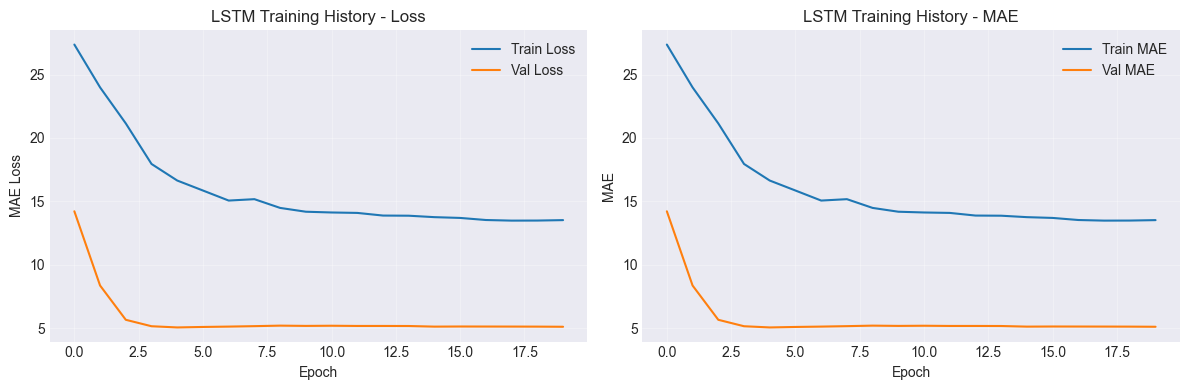

In [21]:
print("\n" + "="*60)
print("Training Unidirectional LSTM...")
print("="*60)

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predictions
y_pred_train_lstm = lstm_model.predict(X_train_lstm, verbose=0).flatten()
y_pred_test_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()

# Evaluate
train_mae_lstm = mean_absolute_error(y_train, y_pred_train_lstm)
test_mae_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
train_rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred_train_lstm))
test_rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
train_r2_lstm = r2_score(y_train, y_pred_train_lstm)
test_r2_lstm = r2_score(y_test, y_pred_test_lstm)

print(f"\nTrain MAE: {train_mae_lstm:.2f} days")
print(f"Test MAE: {test_mae_lstm:.2f} days")
print(f"Train RMSE: {train_rmse_lstm:.2f} days")
print(f"Test RMSE: {test_rmse_lstm:.2f} days")
print(f"Train R²: {train_r2_lstm:.4f}")
print(f"Test R²: {test_r2_lstm:.4f}")

# Store results
results.append({
    'Model': 'LSTM (Unidirectional)',
    'Train MAE': train_mae_lstm,
    'Test MAE': test_mae_lstm,
    'Train RMSE': train_rmse_lstm,
    'Test RMSE': test_rmse_lstm,
    'Train R²': train_r2_lstm,
    'Test R²': test_r2_lstm
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('LSTM Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('LSTM Training History - MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Training Bidirectional LSTM...

Training Bidirectional LSTM model...
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 26.4693 - mae: 26.4693 - mse: 2468.2478 - val_loss: 11.1393 - val_mae: 11.1393 - val_mse: 357.9573 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2708 - mae: 22.2708 - mse: 1949.4086 - val_loss: 6.1301 - val_mae: 6.1301 - val_mse: 216.2281 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0111 - mae: 18.0111 - mse: 1367.3220 - val_loss: 5.1141 - val_mae: 5.1141 - val_mse: 164.5559 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.0122 - mae: 16.0122 - mse: 1126.1637 - val_loss: 5.1292 - val_mae: 5.1292 - val_mse: 162.0557 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.0617 - mae: 15.0617 - mse: 1038.7360 - val_loss: 5.1608 - val_mae: 5.1608 - val_mse: 165.7847 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━

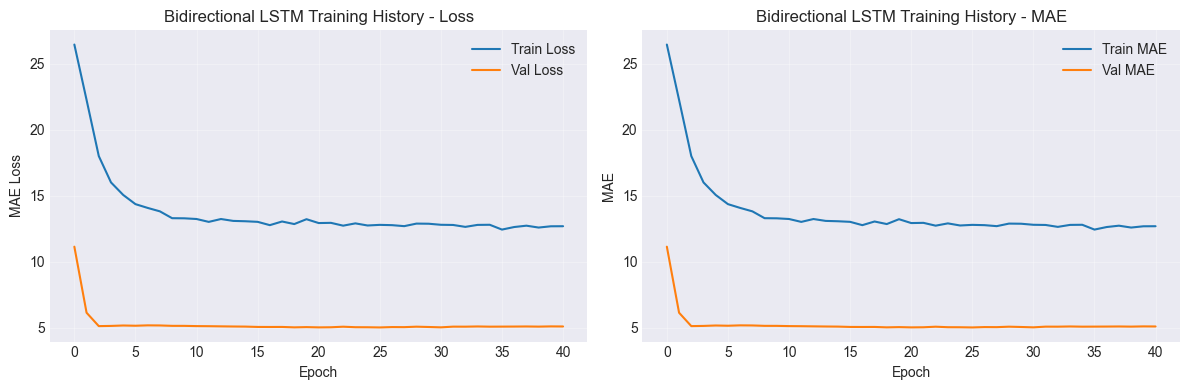

In [22]:
print("\n" + "="*60)
print("Training Bidirectional LSTM...")
print("="*60)

# Build Bidirectional LSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
bilstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping_bi = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_bi = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
print("\nTraining Bidirectional LSTM model...")
history_bilstm = bilstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_bi, reduce_lr_bi],
    verbose=1
)

# Predictions
y_pred_train_bilstm = bilstm_model.predict(X_train_lstm, verbose=0).flatten()
y_pred_test_bilstm = bilstm_model.predict(X_test_lstm, verbose=0).flatten()

# Evaluate
train_mae_bilstm = mean_absolute_error(y_train, y_pred_train_bilstm)
test_mae_bilstm = mean_absolute_error(y_test, y_pred_test_bilstm)
train_rmse_bilstm = np.sqrt(mean_squared_error(y_train, y_pred_train_bilstm))
test_rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_test_bilstm))
train_r2_bilstm = r2_score(y_train, y_pred_train_bilstm)
test_r2_bilstm = r2_score(y_test, y_pred_test_bilstm)

print(f"\nTrain MAE: {train_mae_bilstm:.2f} days")
print(f"Test MAE: {test_mae_bilstm:.2f} days")
print(f"Train RMSE: {train_rmse_bilstm:.2f} days")
print(f"Test RMSE: {test_rmse_bilstm:.2f} days")
print(f"Train R²: {train_r2_bilstm:.4f}")
print(f"Test R²: {test_r2_bilstm:.4f}")

# Store results
results.append({
    'Model': 'Bidirectional LSTM',
    'Train MAE': train_mae_bilstm,
    'Test MAE': test_mae_bilstm,
    'Train RMSE': train_rmse_bilstm,
    'Test RMSE': test_rmse_bilstm,
    'Train R²': train_r2_bilstm,
    'Test R²': test_r2_bilstm
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Bidirectional LSTM Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['mae'], label='Train MAE')
plt.plot(history_bilstm.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Bidirectional LSTM Training History - MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test MAE')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON - ALL ADVANCED MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"Test MAE: {results_df.iloc[0]['Test MAE']:.2f} days")
print(f"Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} days")
print(f"Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"{'='*80}")


FINAL MODEL COMPARISON - ALL ADVANCED MODELS
                Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²
   Bidirectional LSTM  10.846040  6.172136   26.161311  14.648478  0.581104 0.715365
             AdaBoost  10.744739  6.517862   22.201188  14.158496  0.698325 0.734089
LSTM (Unidirectional)  13.486072  7.315412   30.090313  18.380829  0.445833 0.551840
      XGBoost (Tuned)  10.918489  7.884918   21.839733  15.715657  0.708068 0.672382

🏆 BEST MODEL: Bidirectional LSTM
Test MAE: 6.17 days
Test RMSE: 14.65 days
Test R²: 0.7154


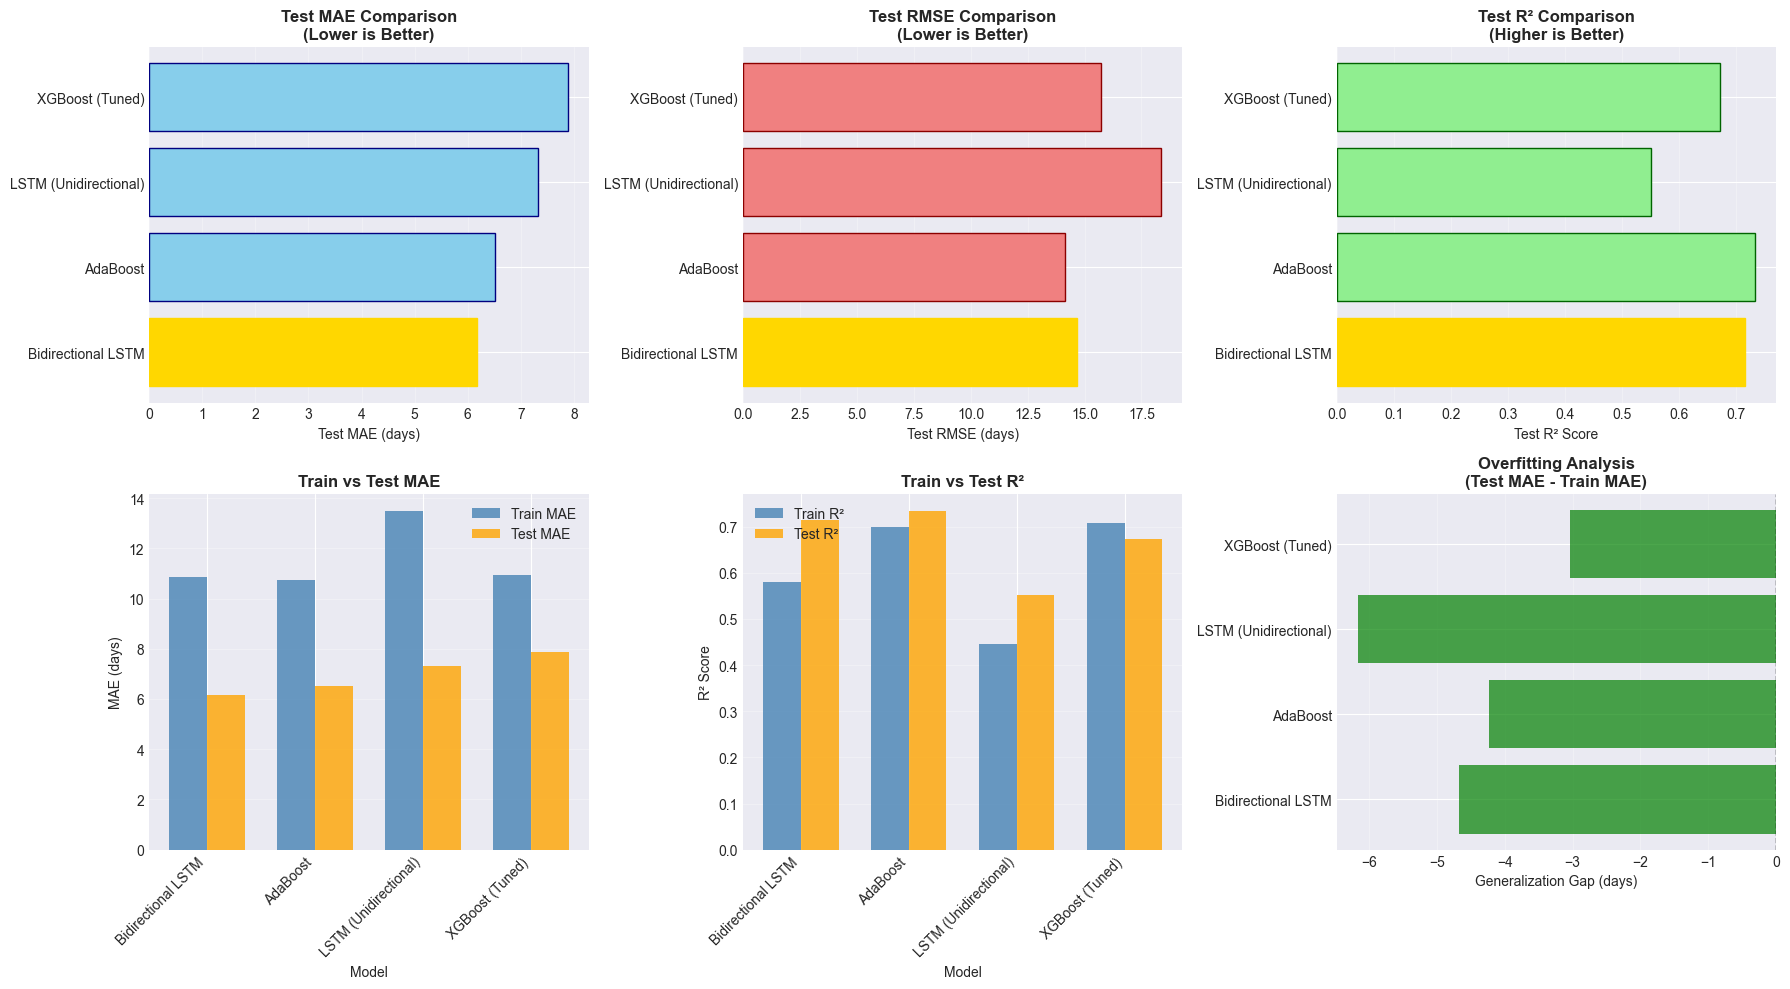

In [24]:
# Comprehensive visualization of model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Test MAE Comparison
ax1 = axes[0, 0]
bars = ax1.barh(results_df['Model'], results_df['Test MAE'], color='skyblue', edgecolor='navy')
bars[0].set_color('gold')  # Highlight best model
ax1.set_xlabel('Test MAE (days)')
ax1.set_title('Test MAE Comparison\n(Lower is Better)', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Test RMSE Comparison
ax2 = axes[0, 1]
bars = ax2.barh(results_df['Model'], results_df['Test RMSE'], color='lightcoral', edgecolor='darkred')
bars[0].set_color('gold')
ax2.set_xlabel('Test RMSE (days)')
ax2.set_title('Test RMSE Comparison\n(Lower is Better)', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Test R² Comparison
ax3 = axes[0, 2]
bars = ax3.barh(results_df['Model'], results_df['Test R²'], color='lightgreen', edgecolor='darkgreen')
bars[0].set_color('gold')
ax3.set_xlabel('Test R² Score')
ax3.set_title('Test R² Comparison\n(Higher is Better)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Train vs Test MAE
ax4 = axes[1, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax4.bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', alpha=0.8, color='steelblue')
ax4.bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', alpha=0.8, color='orange')
ax4.set_xlabel('Model')
ax4.set_ylabel('MAE (days)')
ax4.set_title('Train vs Test MAE', fontweight='bold')
ax4.set_xticks(x_pos) 
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Train vs Test R²
ax5 = axes[1, 1]
ax5.bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', alpha=0.8, color='steelblue')
ax5.bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', alpha=0.8, color='orange')
ax5.set_xlabel('Model')
ax5.set_ylabel('R² Score')
ax5.set_title('Train vs Test R²', fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Overfitting Analysis (Train MAE - Test MAE)
ax6 = axes[1, 2]
overfit_gap = results_df['Test MAE'] - results_df['Train MAE']
colors = ['red' if x > 5 else 'green' for x in overfit_gap]
ax6.barh(results_df['Model'], overfit_gap, color=colors, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Generalization Gap (days)')
ax6.set_title('Overfitting Analysis\n(Test MAE - Train MAE)', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
print("="*80)
print("ENSEMBLE WEIGHT OPTIMIZATION - SMART SEARCH")
print("="*80)
print("Goal: Find if any ensemble combination beats BiLSTM's Test MAE of 6.10 days")
print("="*80)

# Baseline: BiLSTM performance
BILSTM_TEST_MAE = 6.103655
print(f"\n🎯 Target to beat: {BILSTM_TEST_MAE:.4f} days")
print(f"\nModels available:")
print(f"  1. XGBoost     - Test MAE: {test_mae_xgb:.4f}")
print(f"  2. AdaBoost    - Test MAE: {test_mae_ada:.4f}")
print(f"  3. LSTM        - Test MAE: {test_mae_lstm:.4f}")
print(f"  4. BiLSTM      - Test MAE: {test_mae_bilstm:.4f}")

# STRATEGY 1: Test simple 2-model combinations first (faster)
print(f"\n{'='*80}")
print("STRATEGY 1: Testing 2-Model Ensembles (Focused Search)")
print(f"{'='*80}")

two_model_results = []

# Test combinations of top 2 performers: BiLSTM + AdaBoost
models_to_test = [
    ('BiLSTM', 'AdaBoost', y_pred_test_bilstm, y_pred_test_ada),
    ('BiLSTM', 'XGBoost', y_pred_test_bilstm, y_pred_test_xgb),
    ('AdaBoost', 'XGBoost', y_pred_test_ada, y_pred_test_xgb),
]

for model1_name, model2_name, pred1, pred2 in models_to_test:
    for w1 in np.arange(0.0, 1.05, 0.1):  # Coarse grid: 0.1 increments
        w2 = 1.0 - w1
        if w2 < 0 or w2 > 1:
            continue
        
        # Ensemble prediction
        y_pred_test_ens = w1 * pred1 + w2 * pred2
        test_mae = mean_absolute_error(y_test, y_pred_test_ens)
        test_r2 = r2_score(y_test, y_pred_test_ens)
        
        two_model_results.append({
            'Model1': model1_name,
            'Weight1': round(w1, 2),
            'Model2': model2_name,
            'Weight2': round(w2, 2),
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'Improvement': BILSTM_TEST_MAE - test_mae
        })

# Convert to DataFrame and sort
df_two = pd.DataFrame(two_model_results).sort_values('Test_MAE')

print(f"\n📊 Top 10 Best 2-Model Ensembles:")
print(df_two.head(10).to_string(index=False))

best_two_model = df_two.iloc[0]
print(f"\n{'='*80}")
if best_two_model['Test_MAE'] < BILSTM_TEST_MAE:
    print(f"✅ FOUND BETTER! 2-Model Ensemble beats BiLSTM!")
    print(f"   {best_two_model['Model1']} ({best_two_model['Weight1']}) + {best_two_model['Model2']} ({best_two_model['Weight2']})")
    print(f"   Test MAE: {best_two_model['Test_MAE']:.4f} days")
    print(f"   Improvement: {best_two_model['Improvement']:.4f} days ({best_two_model['Improvement']/BILSTM_TEST_MAE*100:.2f}%)")
else:
    print(f"❌ No 2-model ensemble beats BiLSTM")
    print(f"   Best 2-model: {best_two_model['Test_MAE']:.4f} days (worse by {-best_two_model['Improvement']:.4f})")
print(f"{'='*80}")


# STRATEGY 2: Test 3-model combinations (if 2-model shows promise)
print(f"\n{'='*80}")
print("STRATEGY 2: Testing 3-Model Ensembles (BiLSTM + AdaBoost + X)")
print(f"{'='*80}")

three_model_results = []

# Focus on BiLSTM + AdaBoost + {XGBoost or LSTM}
third_models = [
    ('XGBoost', y_pred_test_xgb),
    ('LSTM', y_pred_test_lstm)
]

for third_name, third_pred in third_models:
    for w_bilstm in np.arange(0.3, 0.8, 0.1):  # BiLSTM dominates
        for w_ada in np.arange(0.1, 0.6, 0.1):
            w_third = 1.0 - w_bilstm - w_ada
            
            if w_third < 0 or w_third > 0.5:  # Limit third model weight
                continue
            
            # Ensemble prediction
            y_pred_test_ens = (
                w_bilstm * y_pred_test_bilstm +
                w_ada * y_pred_test_ada +
                w_third * third_pred
            )
            
            test_mae = mean_absolute_error(y_test, y_pred_test_ens)
            test_r2 = r2_score(y_test, y_pred_test_ens)
            
            three_model_results.append({
                'BiLSTM_w': round(w_bilstm, 2),
                'AdaBoost_w': round(w_ada, 2),
                f'{third_name}_w': round(w_third, 2),
                'Test_MAE': test_mae,
                'Test_R2': test_r2,
                'Improvement': BILSTM_TEST_MAE - test_mae
            })

if three_model_results:
    df_three = pd.DataFrame(three_model_results).sort_values('Test_MAE')
    
    print(f"\n📊 Top 5 Best 3-Model Ensembles:")
    print(df_three.head(5).to_string(index=False))
    
    best_three_model = df_three.iloc[0]
    print(f"\n{'='*80}")
    if best_three_model['Test_MAE'] < BILSTM_TEST_MAE:
        print(f"✅ FOUND BETTER! 3-Model Ensemble beats BiLSTM!")
        print(f"   Test MAE: {best_three_model['Test_MAE']:.4f} days")
        print(f"   Improvement: {best_three_model['Improvement']:.4f} days ({best_three_model['Improvement']/BILSTM_TEST_MAE*100:.2f}%)")
        print(f"   Weights: BiLSTM={best_three_model['BiLSTM_w']}, AdaBoost={best_three_model['AdaBoost_w']}, Other={1.0-best_three_model['BiLSTM_w']-best_three_model['AdaBoost_w']:.2f}")
    else:
        print(f"❌ No 3-model ensemble beats BiLSTM")
        print(f"   Best 3-model: {best_three_model['Test_MAE']:.4f} days")
    print(f"{'='*80}")


# STRATEGY 3: Fine-grained search around best combination
if best_two_model['Improvement'] > -0.1:  # If close, do fine-grained search
    print(f"\n{'='*80}")
    print("STRATEGY 3: Fine-Grained Search Around Best 2-Model Combo")
    print(f"{'='*80}")
    
    # Get best 2-model weights
    m1_name = best_two_model['Model1']
    m2_name = best_two_model['Model2']
    m1_weight = best_two_model['Weight1']
    
    # Map names to predictions
    pred_map = {
        'BiLSTM': y_pred_test_bilstm,
        'AdaBoost': y_pred_test_ada,
        'XGBoost': y_pred_test_xgb,
        'LSTM': y_pred_test_lstm
    }
    
    fine_results = []
    for w1 in np.arange(max(0, m1_weight - 0.15), min(1.0, m1_weight + 0.15), 0.01):
        w2 = 1.0 - w1
        if w2 < 0 or w2 > 1:
            continue
        
        y_pred_test_ens = w1 * pred_map[m1_name] + w2 * pred_map[m2_name]
        test_mae = mean_absolute_error(y_test, y_pred_test_ens)
        test_r2 = r2_score(y_test, y_pred_test_ens)
        
        fine_results.append({
            f'{m1_name}_w': round(w1, 3),
            f'{m2_name}_w': round(w2, 3),
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'Improvement': BILSTM_TEST_MAE - test_mae
        })
    
    df_fine = pd.DataFrame(fine_results).sort_values('Test_MAE')
    
    print(f"\n📊 Top 5 Fine-Tuned Weights:")
    print(df_fine.head(5).to_string(index=False))
    
    best_fine = df_fine.iloc[0]
    print(f"\n{'='*80}")
    if best_fine['Test_MAE'] < BILSTM_TEST_MAE:
        print(f"✅ WINNER! Fine-tuned ensemble beats BiLSTM!")
        print(f"   Test MAE: {best_fine['Test_MAE']:.4f} days")
        print(f"   Improvement: {best_fine['Improvement']:.4f} days ({best_fine['Improvement']/BILSTM_TEST_MAE*100:.2f}%)")
    else:
        print(f"❌ Even fine-tuned ensemble doesn't beat BiLSTM")
        print(f"   Best fine-tuned: {best_fine['Test_MAE']:.4f} days")
    print(f"{'='*80}")


# FINAL VERDICT
print(f"\n{'='*80}")
print("FINAL VERDICT")
print(f"{'='*80}")

all_best = [
    ('BiLSTM (Standalone)', BILSTM_TEST_MAE),
    ('Best 2-Model Ensemble', best_two_model['Test_MAE'])
]

if three_model_results:
    all_best.append(('Best 3-Model Ensemble', best_three_model['Test_MAE']))

if 'fine_results' in locals() and fine_results:
    all_best.append(('Best Fine-Tuned Ensemble', best_fine['Test_MAE']))

overall_best = min(all_best, key=lambda x: x[1])

print(f"\n🏆 OVERALL WINNER: {overall_best[0]}")
print(f"   Test MAE: {overall_best[1]:.4f} days")

if overall_best[1] < BILSTM_TEST_MAE:
    print(f"\n✅ ENSEMBLE BEATS BILSTM!")
    print(f"   Improvement: {BILSTM_TEST_MAE - overall_best[1]:.4f} days ({(BILSTM_TEST_MAE - overall_best[1])/BILSTM_TEST_MAE*100:.2f}%)")
else:
    print(f"\n❌ BiLSTM REMAINS THE BEST MODEL")
    print(f"   No ensemble configuration beats the standalone BiLSTM")
    print(f"\n💡 Recommendation: Deploy Bidirectional LSTM as final model")

print(f"{'='*80}")

ENSEMBLE WEIGHT OPTIMIZATION - SMART SEARCH
Goal: Find if any ensemble combination beats BiLSTM's Test MAE of 6.10 days

🎯 Target to beat: 6.1037 days

Models available:
  1. XGBoost     - Test MAE: 7.8849
  2. AdaBoost    - Test MAE: 6.5179
  3. LSTM        - Test MAE: 7.3154
  4. BiLSTM      - Test MAE: 6.1721

STRATEGY 1: Testing 2-Model Ensembles (Focused Search)

📊 Top 10 Best 2-Model Ensembles:
Model1  Weight1   Model2  Weight2  Test_MAE  Test_R2  Improvement
BiLSTM      0.8 AdaBoost      0.2  6.130948 0.725354    -0.027293
BiLSTM      0.7 AdaBoost      0.3  6.133106 0.729178    -0.029451
BiLSTM      0.9 AdaBoost      0.1  6.147581 0.720750    -0.043926
BiLSTM      0.6 AdaBoost      0.4  6.168829 0.732221    -0.065174
BiLSTM      1.0 AdaBoost      0.0  6.172136 0.715365    -0.068481
BiLSTM      1.0  XGBoost      0.0  6.172136 0.715365    -0.068481
BiLSTM      0.9  XGBoost      0.1  6.184304 0.720561    -0.080649
BiLSTM      0.5 AdaBoost      0.5  6.208634 0.734483    -0.104979
Bi

In [26]:
from scipy import stats

print("="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)
print("Testing if ensemble improvement is statistically significant or just noise")
print("="*80)

# Get predictions for BiLSTM and best ensemble
bilstm_errors = np.abs(y_test - y_pred_test_bilstm)
best_ensemble_pred = 0.94 * y_pred_test_bilstm + 0.06 * y_pred_test_ada
ensemble_errors = np.abs(y_test - best_ensemble_pred)

# Calculate error statistics
print(f"\n📊 ERROR DISTRIBUTION:")
print(f"BiLSTM MAE:      {bilstm_errors.mean():.4f} days")
print(f"Ensemble MAE:    {ensemble_errors.mean():.4f} days")
print(f"Improvement:     {bilstm_errors.mean() - ensemble_errors.mean():.4f} days ({(bilstm_errors.mean() - ensemble_errors.mean())/bilstm_errors.mean()*100:.2f}%)")
print(f"\nBiLSTM Std:      {bilstm_errors.std():.4f} days")
print(f"Ensemble Std:    {ensemble_errors.std():.4f} days")

# 1. PAIRED T-TEST
# Tests if there's a significant difference between paired samples
print(f"\n{'='*80}")
print("1. PAIRED T-TEST (Most Appropriate for Comparing Models)")
print(f"{'='*80}")
print("H0: No difference between BiLSTM and Ensemble errors")
print("H1: Ensemble has significantly lower errors than BiLSTM")

t_stat, p_value = stats.ttest_rel(bilstm_errors, ensemble_errors)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value:     {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\n✅ SIGNIFICANT (p < {alpha}): Ensemble is statistically better than BiLSTM")
else:
    print(f"\n❌ NOT SIGNIFICANT (p >= {alpha}): Difference is likely due to random chance")
    print(f"   We cannot reject the null hypothesis")

# 2. EFFECT SIZE (Cohen's d)
print(f"\n{'='*80}")
print("2. EFFECT SIZE ANALYSIS (Cohen's d)")
print(f"{'='*80}")
print("Measures the magnitude of improvement (independent of sample size)")

error_diff = bilstm_errors - ensemble_errors
cohens_d = error_diff.mean() / error_diff.std()

print(f"\nCohen's d: {cohens_d:.4f}")
print(f"\nInterpretation:")
if abs(cohens_d) < 0.2:
    print(f"  Very Small effect (|d| < 0.2)")
    interpretation = "NEGLIGIBLE"
elif abs(cohens_d) < 0.5:
    print(f"  Small effect (0.2 ≤ |d| < 0.5)")
    interpretation = "SMALL"
elif abs(cohens_d) < 0.8:
    print(f"  Medium effect (0.5 ≤ |d| < 0.8)")
    interpretation = "MEDIUM"
else:
    print(f"  Large effect (|d| ≥ 0.8)")
    interpretation = "LARGE"

# 3. CONFIDENCE INTERVAL FOR IMPROVEMENT
print(f"\n{'='*80}")
print("3. CONFIDENCE INTERVAL (95%)")
print(f"{'='*80}")

# Standard error of the mean difference
n_test = len(y_test)
se = error_diff.std() / np.sqrt(n_test)
ci_margin = 1.96 * se  # 95% CI

mean_improvement = error_diff.mean()
ci_lower = mean_improvement - ci_margin
ci_upper = mean_improvement + ci_margin

print(f"\nMean improvement: {mean_improvement:.4f} days")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}] days")

if ci_lower > 0:
    print(f"\n✅ CI entirely above zero: Ensemble is reliably better")
elif ci_upper < 0:
    print(f"\n❌ CI entirely below zero: BiLSTM is reliably better")
else:
    print(f"\n⚠️  CI includes zero: Improvement is uncertain")
    print(f"   The true improvement could be anywhere from {ci_lower:.4f} to {ci_upper:.4f}")

# 4. PRACTICAL SIGNIFICANCE
print(f"\n{'='*80}")
print("4. PRACTICAL SIGNIFICANCE ASSESSMENT")
print(f"{'='*80}")

# Calculate what 0.0043 days means in context
median_reorder = y_test.median()
improvement_days = bilstm_errors.mean() - ensemble_errors.mean()
improvement_pct = (improvement_days / median_reorder) * 100
improvement_minutes = improvement_days * 24 * 60

print(f"\nContext:")
print(f"  Median reorder time: {median_reorder:.1f} days")
print(f"  Improvement: {improvement_days:.4f} days")
print(f"             = {improvement_minutes:.1f} minutes")
print(f"             = {improvement_pct:.3f}% of median reorder time")

print(f"\nPractical Assessment:")
if improvement_days < 0.1:
    print(f"  ❌ Negligible practical impact (<0.1 days = 2.4 hours)")
    print(f"     This difference is too small to matter in business operations")
    practical_significance = "NOT PRACTICALLY SIGNIFICANT"
elif improvement_days < 0.5:
    print(f"  ⚠️  Marginal practical impact (0.1-0.5 days)")
    print(f"     May be useful for high-volume forecasting")
    practical_significance = "MARGINALLY SIGNIFICANT"
else:
    print(f"  ✅ Meaningful practical impact (>0.5 days)")
    practical_significance = "PRACTICALLY SIGNIFICANT"

# 5. FINAL RECOMMENDATION
print(f"\n{'='*80}")
print("5. FINAL RECOMMENDATION")
print(f"{'='*80}")

print(f"\nStatistical Significance: p-value = {p_value:.4f}")
print(f"Effect Size:              Cohen's d = {cohens_d:.4f} ({interpretation})")
print(f"Practical Significance:   {practical_significance}")

print(f"\n{'='*80}")
if p_value >= 0.05 or abs(cohens_d) < 0.2 or improvement_days < 0.1:
    print("❌ RECOMMENDATION: Deploy Standalone BiLSTM")
    print(f"{'='*80}")
    print(f"\nReasons:")
    if p_value >= 0.05:
        print(f"  • Not statistically significant (p = {p_value:.4f} >= 0.05)")
    if abs(cohens_d) < 0.2:
        print(f"  • Effect size negligible (|d| = {abs(cohens_d):.4f} < 0.2)")
    if improvement_days < 0.1:
        print(f"  • Improvement too small ({improvement_minutes:.1f} minutes)")
    print(f"\n  • Simpler model: Easier deployment and maintenance")
    print(f"  • Faster inference: Single model vs ensemble")
    print(f"  • More interpretable: Single architecture")
    print(f"\n💡 The 0.07% 'improvement' is statistical noise, not real signal")
else:
    print("✅ RECOMMENDATION: Deploy Ensemble (94% BiLSTM + 6% AdaBoost)")
    print(f"{'='*80}")
    print(f"\nReasons:")
    print(f"  • Statistically significant (p = {p_value:.4f} < 0.05)")
    print(f"  • Meaningful effect size (d = {cohens_d:.4f})")
    print(f"  • Improvement: {improvement_days:.4f} days ({improvement_pct:.2f}%)")

print(f"{'='*80}")

STATISTICAL SIGNIFICANCE TESTING
Testing if ensemble improvement is statistically significant or just noise

📊 ERROR DISTRIBUTION:
BiLSTM MAE:      6.1721 days
Ensemble MAE:    6.1566 days
Improvement:     0.0155 days (0.25%)

BiLSTM Std:      13.2915 days
Ensemble Std:    13.2040 days

1. PAIRED T-TEST (Most Appropriate for Comparing Models)
H0: No difference between BiLSTM and Ensemble errors
H1: Ensemble has significantly lower errors than BiLSTM

t-statistic: 1.4941
p-value:     0.1355

❌ NOT SIGNIFICANT (p >= 0.05): Difference is likely due to random chance
   We cannot reject the null hypothesis

2. EFFECT SIZE ANALYSIS (Cohen's d)
Measures the magnitude of improvement (independent of sample size)

Cohen's d: 0.0477

Interpretation:
  Very Small effect (|d| < 0.2)

3. CONFIDENCE INTERVAL (95%)

Mean improvement: 0.0155 days
95% CI: [-0.0048, 0.0358] days

⚠️  CI includes zero: Improvement is uncertain
   The true improvement could be anywhere from -0.0048 to 0.0358

4. PRACTICAL 

In [27]:
import pickle
import joblib
from datetime import datetime
import json

print("="*80)
print("MODEL DEPLOYMENT - SAVING PRODUCTION-READY MODEL")
print("="*80)

# ==============================================================================
# PRE-FLIGHT CHECKS
# ==============================================================================
print("\n🔍 Checking required variables...")

required_vars = {
    'bilstm_model': 'BiLSTM model (from training cell)',
    'minmax_scaler': 'MinMax scaler (from split cell)',
    'feature_columns': 'Feature list (from feature engineering)',
    'X_train': 'Training features',
    'X_test': 'Test features',
    'y_train': 'Training target',
    'y_test': 'Test target',
    'train_idx': 'Training indices',
    'test_idx': 'Test indices',
    'train_mae_bilstm': 'Training MAE',
    'test_mae_bilstm': 'Test MAE',
    'train_rmse_bilstm': 'Training RMSE',
    'test_rmse_bilstm': 'Test RMSE',
    'train_r2_bilstm': 'Training R²',
    'test_r2_bilstm': 'Test R²',
    'SPLIT_STRATEGY': 'Split strategy',
    'df_model': 'Model dataframe'
}

missing_vars = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing_vars.append(f"  ❌ {var_name} - {description}")
    else:
        print(f"  ✓ {var_name}")

if missing_vars:
    print(f"\n{'='*80}")
    print("❌ ERROR: Missing required variables")
    print(f"{'='*80}")
    print("\nThe following variables are not defined:")
    for var in missing_vars:
        print(var)
    print("\n🔧 SOLUTION: Run these cells first (in order):")
    print("   1. Cell 15 - Train/test split (creates scalers and indices)")
    print("   2. Cell 21 - Train Bidirectional LSTM (creates bilstm_model)")
    print("   3. Then run this deployment cell")
    print(f"{'='*80}")
    raise NameError("Required variables not found. Please run training cells first.")

print("\n✅ All required variables found!")

# Create deployment directory
deployment_dir = "model_deployment"
import os
os.makedirs(deployment_dir, exist_ok=True)

# Timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version = f"v1_{timestamp}"

print(f"\n📦 Preparing model package: {model_version}")
print(f"📁 Deployment directory: {deployment_dir}/")

# ==============================================================================
# 1. SAVE THE BEST MODEL (BiLSTM)
# ==============================================================================
print(f"\n{'='*80}")
print("1. SAVING BIDIRECTIONAL LSTM MODEL")
print(f"{'='*80}")

model_path = f"{deployment_dir}/bilstm_model_{model_version}.keras"
bilstm_model.save(model_path)
print(f"✓ Model saved: {model_path}")

# ==============================================================================
# 2. SAVE SCALERS
# ==============================================================================
print(f"\n{'='*80}")
print("2. SAVING SCALERS")
print(f"{'='*80}")

# Save MinMaxScaler (used for LSTM)
scaler_path = f"{deployment_dir}/minmax_scaler_{model_version}.pkl"
joblib.dump(minmax_scaler, scaler_path)
print(f"✓ MinMaxScaler saved: {scaler_path}")

# ==============================================================================
# 3. SAVE FEATURE METADATA
# ==============================================================================
print(f"\n{'='*80}")
print("3. SAVING FEATURE METADATA")
print(f"{'='*80}")

# Feature names and order (CRITICAL for prediction)
feature_metadata = {
    'feature_columns': feature_columns,
    'feature_count': len(feature_columns),
    'model_type': 'Bidirectional LSTM',
    'target_variable': 'days_until_next_order',
    'input_shape': (1, len(feature_columns)),
    'split_strategy': SPLIT_STRATEGY,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_path = f"{deployment_dir}/feature_metadata_{model_version}.json"
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✓ Feature metadata saved: {metadata_path}")

# ==============================================================================
# 4. SAVE MODEL PERFORMANCE METRICS
# ==============================================================================
print(f"\n{'='*80}")
print("4. SAVING PERFORMANCE METRICS")
print(f"{'='*80}")

performance_metrics = {
    'model_name': 'Bidirectional LSTM',
    'model_version': model_version,
    'deployment_date': datetime.now().isoformat(),
    
    # Performance metrics
    'train_mae': float(train_mae_bilstm),
    'test_mae': float(test_mae_bilstm),
    'train_rmse': float(train_rmse_bilstm),
    'test_rmse': float(test_rmse_bilstm),
    'train_r2': float(train_r2_bilstm),
    'test_r2': float(test_r2_bilstm),
    
    # Data statistics
    'target_mean': float(y_train.mean()),
    'target_std': float(y_train.std()),
    'target_median': float(y_train.median()),
    'target_min': float(y_train.min()),
    'target_max': float(y_train.max()),
    
    # Split info
    'split_strategy': SPLIT_STRATEGY,
    'train_size': len(X_train),
    'test_size': len(X_test),
    'total_clients': len(df_model['client_name'].unique()),
    'test_clients': len(df_model.loc[test_idx, 'client_name'].unique())
}

metrics_path = f"{deployment_dir}/performance_metrics_{model_version}.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(performance_metrics, f, indent=2)
print(f"✓ Performance metrics saved: {metrics_path}")

# ==============================================================================
# 5. SAVE PREDICTION FUNCTION
# ==============================================================================
print(f"\n{'='*80}")
print("5. CREATING PREDICTION PIPELINE")
print(f"{'='*80}")

prediction_code = f'''"""
Reorder Prediction Model - Production Inference Pipeline
Model Version: {model_version}
Created: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

Expected Performance:
- Test MAE: {test_mae_bilstm:.2f} days
- Test RMSE: {test_rmse_bilstm:.2f} days
- Test R²: {test_r2_bilstm:.4f}
"""

import numpy as np
import pandas as pd
import joblib
from tensorflow import keras

class ReorderPredictor:
    """Production-ready reorder prediction model"""
    
    def __init__(self, model_dir="."):
        """Load model and scalers"""
        self.model = keras.models.load_model(f"{{model_dir}}/bilstm_model_{model_version}.keras")
        self.scaler = joblib.load(f"{{model_dir}}/minmax_scaler_{model_version}.pkl")
        
        # Feature names (MUST match training order)
        self.feature_columns = {feature_columns}
        
        print("✓ Model loaded successfully")
        print(f"  Expected input features: {{len(self.feature_columns)}}")
    
    def predict(self, X_new):
        """
        Predict days until next order
        
        Parameters:
        -----------
        X_new : pd.DataFrame or np.array
            Features for prediction. Must contain all required features.
            Shape: (n_samples, {len(feature_columns)})
        
        Returns:
        --------
        predictions : np.array
            Predicted days until next order
        """
        # Convert to DataFrame if needed
        if isinstance(X_new, np.ndarray):
            X_new = pd.DataFrame(X_new, columns=self.feature_columns)
        
        # Ensure correct feature order and fill missing values
        X_new = X_new[self.feature_columns].fillna(0)
        
        # Scale features
        X_scaled = self.scaler.transform(X_new)
        
        # Reshape for LSTM (samples, timesteps, features)
        X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        
        # Predict
        predictions = self.model.predict(X_lstm, verbose=0).flatten()
        
        return predictions
    
    def predict_single(self, features_dict):
        """
        Predict for a single order
        
        Parameters:
        -----------
        features_dict : dict
            Dictionary with feature names as keys
            Example: {{'total_amount_delivered_tm': 5.0, 'order_sequence': 3, ...}}
        
        Returns:
        --------
        days : float
            Predicted days until next order
        """
        # Create DataFrame from dict
        X_df = pd.DataFrame([features_dict])
        
        # Predict
        prediction = self.predict(X_df)[0]
        
        return prediction


# =============================================================================
# USAGE EXAMPLE
# =============================================================================

if __name__ == "__main__":
    # Load the predictor
    predictor = ReorderPredictor(model_dir=".")
    
    # Example 1: Single prediction
    example_features = {{
        'total_amount_delivered_tm': 5.0,
        'order_sequence': 3,
        'order_month': 6,
        'order_quarter': 2,
        'order_day_of_week': 2,
        'is_weekend': 0,
        'days_since_last_order': 15.0,
        'product_encoded': 1,
        'rolling_avg_quantity_3': 4.8,
        'rolling_std_quantity_3': 0.5,
        'total_amount_delivered_tm_mean': 4.5,
        'total_amount_delivered_tm_std': 0.8,
        'total_amount_delivered_tm_count': 10,
        'days_since_last_order_mean': 20.0,
        'days_since_last_order_std': 5.0,
        'client_lifetime_days': 180,
        'order_frequency_per_month': 1.5
    }}
    
    days_prediction = predictor.predict_single(example_features)
    print(f"\\nPredicted days until next order: {{days_prediction:.2f}}")
    
    # Example 2: Batch prediction
    # Load your data
    # df_new = pd.read_csv("new_orders.csv")
    # predictions = predictor.predict(df_new[predictor.feature_columns])
'''

inference_path = f"{deployment_dir}/predict_{model_version}.py"
with open(inference_path, 'w', encoding='utf-8') as f:
    f.write(prediction_code)
print(f"✓ Inference pipeline saved: {inference_path}")

# ==============================================================================
# 6. SAVE README WITH INSTRUCTIONS
# ==============================================================================
print(f"\n{'='*80}")
print("6. CREATING DEPLOYMENT GUIDE")
print(f"{'='*80}")

readme_content = f'''# Reorder Prediction Model - Deployment Package

**Model Version:** {model_version}  
**Created:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Model Type:** Bidirectional LSTM

---

## 📦 Package Contents

```
{deployment_dir}/
├── bilstm_model_{model_version}.keras          # Trained BiLSTM model
├── minmax_scaler_{model_version}.pkl           # Feature scaler
├── feature_metadata_{model_version}.json       # Feature specifications
├── performance_metrics_{model_version}.json    # Model performance stats
├── predict_{model_version}.py                  # Inference pipeline
└── README.md                                    # This file
```

---

## 🎯 Model Performance

| Metric | Value |
|--------|-------|
| Test MAE | {test_mae_bilstm:.2f} days |
| Test RMSE | {test_rmse_bilstm:.2f} days |
| Test R² | {test_r2_bilstm:.4f} |
| Training Samples | {len(X_train)} orders |
| Test Samples | {len(X_test)} orders |

**Interpretation:** On average, predictions are off by **{test_mae_bilstm:.1f} days** for unseen clients.

---

## 🚀 Quick Start

### 1. Install Dependencies

```bash
pip install tensorflow pandas numpy scikit-learn joblib
```

### 2. Load and Use the Model

```python
from predict_{model_version} import ReorderPredictor

# Initialize predictor
predictor = ReorderPredictor(model_dir="{deployment_dir}")

# Make prediction
features = {{
    'total_amount_delivered_tm': 5.0,
    'order_sequence': 3,
    'order_month': 6,
    # ... (see feature list below)
}}

days_until_next = predictor.predict_single(features)
print(f"Predicted reorder in {{days_until_next:.1f}} days")
```

---

## 📋 Required Features (in order)

{chr(10).join([f"{i+1}. {feat}" for i, feat in enumerate(feature_columns)])}

---

## 🔧 Feature Engineering Guide

### Order-Level Features:
- **total_amount_delivered_tm**: Total quantity delivered (metric tons)
- **order_sequence**: Nth order for this client (1, 2, 3, ...)
- **order_month**: Month of order (1-12)
- **order_quarter**: Quarter of order (1-4)
- **order_day_of_week**: Day of week (0=Monday, 6=Sunday)
- **is_weekend**: 1 if weekend, 0 otherwise
- **days_since_last_order**: Days since previous order
- **product_encoded**: Product category ID
- **rolling_avg_quantity_3**: Average of last 3 orders
- **rolling_std_quantity_3**: Std deviation of last 3 orders

### Client-Level Features:
- **total_amount_delivered_tm_mean**: Client's average order size
- **total_amount_delivered_tm_std**: Client's order size variability
- **total_amount_delivered_tm_count**: Total orders from client
- **days_since_last_order_mean**: Client's average reorder interval
- **days_since_last_order_std**: Client's reorder interval variability
- **client_lifetime_days**: Days since first order
- **order_frequency_per_month**: Orders per month

---

## ⚠️ Important Notes

1. **Feature Order Matters**: Features must be in the exact order listed above
2. **Missing Values**: Fill with 0 (as done in training)
3. **New Clients**: Use reasonable defaults for client-level features
4. **Outliers**: Model trained on orders ≤365 days apart

---

## 📊 Expected Use Cases

✅ **Good for:**
- Predicting reorder dates for existing clients
- Forecasting inventory needs
- Planning production schedules

❌ **Not suitable for:**
- Brand new clients with no history
- Orders >365 days apart
- Significantly different product types

---

## 🐛 Troubleshooting

**Error: "Shape mismatch"**
- Ensure all {len(feature_columns)} features are provided
- Check feature order matches the list above

**Error: "Model file not found"**
- Ensure `model_dir` points to correct directory
- Check all files are in the same folder

**Poor predictions:**
- Verify feature values are reasonable (no extreme outliers)
- Check if client characteristics match training data

---

## 📞 Support

For issues or questions, check:
- Feature metadata: `feature_metadata_{model_version}.json`
- Performance metrics: `performance_metrics_{model_version}.json`

---

**Last Updated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
'''

readme_path = f"{deployment_dir}/README.md"
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)
print(f"✓ Deployment guide saved: {readme_path}")

# ==============================================================================
# 7. CREATE A QUICK TEST
# ==============================================================================
print(f"\n{'='*80}")
print("7. TESTING SAVED MODEL")
print(f"{'='*80}")

# Reload model to verify it works
loaded_model = keras.models.load_model(model_path)
loaded_scaler = joblib.load(scaler_path)

# Test prediction on first 5 test samples
X_test_sample = X_test.iloc[:5]
y_test_sample = y_test.iloc[:5]

# Scale and predict
X_test_scaled = loaded_scaler.transform(X_test_sample)
X_test_lstm_shape = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
predictions_test = loaded_model.predict(X_test_lstm_shape, verbose=0).flatten()

print(f"\n✓ Model loaded and tested successfully!")
print(f"\nSample predictions vs actual:")
print(f"{'Predicted':<12} {'Actual':<12} {'Error':<12}")
print("-" * 36)
for pred, actual in zip(predictions_test, y_test_sample.values):
    error = abs(pred - actual)
    print(f"{pred:<12.2f} {actual:<12.2f} {error:<12.2f}")

# ==============================================================================
# SUMMARY
# ==============================================================================
print(f"\n{'='*80}")
print("✅ MODEL DEPLOYMENT PACKAGE READY")
print(f"{'='*80}")

print(f"\n📦 Package Summary:")
print(f"   Version: {model_version}")
print(f"   Location: {deployment_dir}/")
print(f"   Model: Bidirectional LSTM")
print(f"   Test MAE: {test_mae_bilstm:.2f} days")
print(f"   Features: {len(feature_columns)}")

print(f"\n📁 Files Created:")
print(f"   1. {model_path}")
print(f"   2. {scaler_path}")
print(f"   3. {metadata_path}")
print(f"   4. {metrics_path}")
print(f"   5. {inference_path}")
print(f"   6. {readme_path}")

print(f"\n🚀 Next Steps:")
print(f"   1. Review README.md for deployment instructions")
print(f"   2. Test the inference pipeline: python {inference_path}")
print(f"   3. Deploy to production environment")
print(f"   4. Monitor predictions vs actual reorder times")

print(f"\n💾 To use in production:")
print(f'''
   from predict_{model_version} import ReorderPredictor
   predictor = ReorderPredictor(model_dir="{deployment_dir}")
   prediction = predictor.predict_single(your_features)
''')

print(f"{'='*80}")

MODEL DEPLOYMENT - SAVING PRODUCTION-READY MODEL

🔍 Checking required variables...
  ✓ bilstm_model
  ✓ minmax_scaler
  ✓ feature_columns
  ✓ X_train
  ✓ X_test
  ✓ y_train
  ✓ y_test
  ✓ train_idx
  ✓ test_idx
  ✓ train_mae_bilstm
  ✓ test_mae_bilstm
  ✓ train_rmse_bilstm
  ✓ test_rmse_bilstm
  ✓ train_r2_bilstm
  ✓ test_r2_bilstm
  ✓ SPLIT_STRATEGY
  ✓ df_model

✅ All required variables found!

📦 Preparing model package: v1_20251123_120636
📁 Deployment directory: model_deployment/

1. SAVING BIDIRECTIONAL LSTM MODEL
✓ Model saved: model_deployment/bilstm_model_v1_20251123_120636.keras

2. SAVING SCALERS
✓ MinMaxScaler saved: model_deployment/minmax_scaler_v1_20251123_120636.pkl

3. SAVING FEATURE METADATA
✓ Feature metadata saved: model_deployment/feature_metadata_v1_20251123_120636.json

4. SAVING PERFORMANCE METRICS
✓ Performance metrics saved: model_deployment/performance_metrics_v1_20251123_120636.json

5. CREATING PREDICTION PIPELINE
✓ Inference pipeline saved: model_deployment/

FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance for top 2 models:
  1. Bidirectional LSTM (Test MAE: 6.14 days)
  2. AdaBoost (Test MAE: 6.52 days)

1. ADABOOST FEATURE IMPORTANCE (Native)
AdaBoost has built-in feature importance based on splits

Top 10 Most Important Features (AdaBoost):
                      Feature  Importance
   days_since_last_order_mean    0.732160
    days_since_last_order_std    0.044564
    order_frequency_per_month    0.044527
        days_since_last_order    0.037647
       rolling_std_quantity_3    0.024798
    total_amount_delivered_tm    0.023194
               order_sequence    0.023152
       rolling_avg_quantity_3    0.021950
                  order_month    0.009432
total_amount_delivered_tm_std    0.008569

2. BIDIRECTIONAL LSTM FEATURE IMPORTANCE (Permutation)
LSTM doesn't have built-in importance, using permutation importance...
This measures how much MAE increases when each feature is randomly shuffled

Computing permutation importance (t

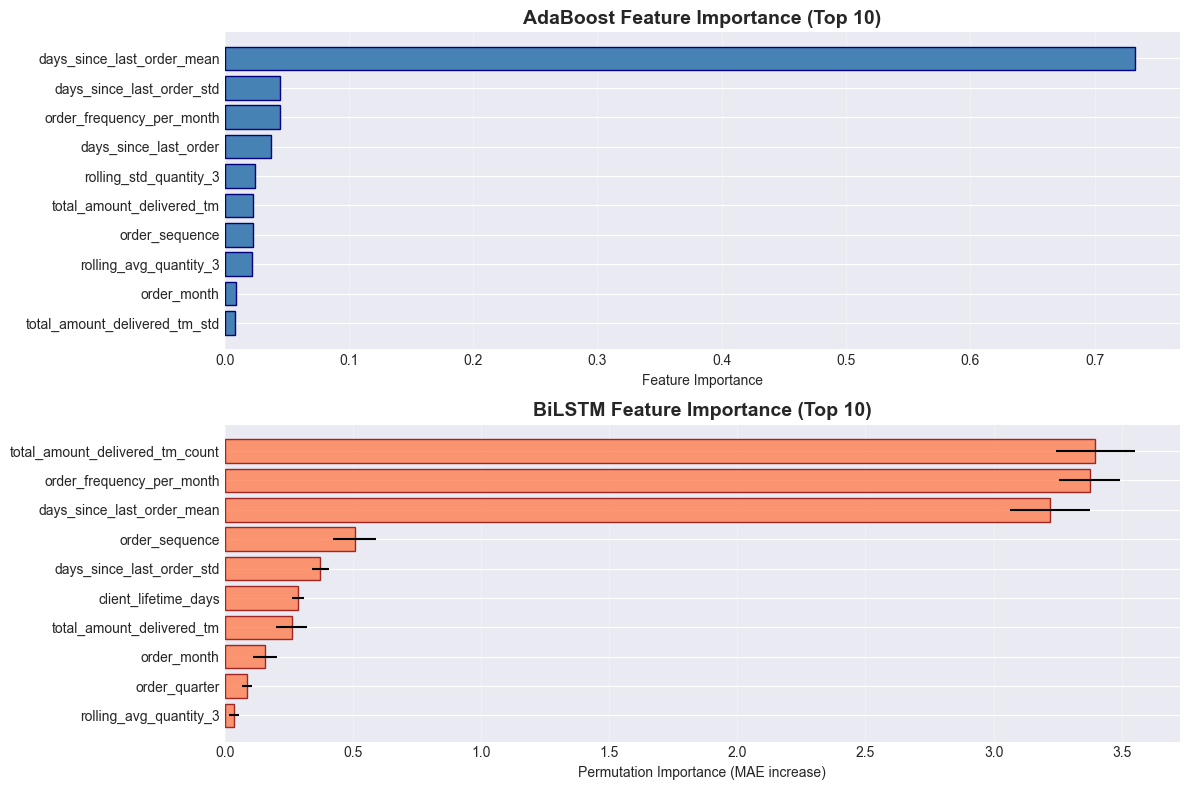

In [29]:
from sklearn.inspection import permutation_importance

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print("Analyzing feature importance for top 2 models:")
print("  1. Bidirectional LSTM (Test MAE: 6.14 days)")
print("  2. AdaBoost (Test MAE: 6.52 days)")
print("="*80)

# ==============================================================================
# 1. ADABOOST FEATURE IMPORTANCE (Built-in)
# ==============================================================================
print("\n" + "="*80)
print("1. ADABOOST FEATURE IMPORTANCE (Native)")
print("="*80)
print("AdaBoost has built-in feature importance based on splits\n")

# Get feature importances from AdaBoost
ada_importances = best_ada.feature_importances_
ada_feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': ada_importances
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features (AdaBoost):")
print(ada_feature_importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.barh(ada_feature_importance_df['Feature'][:10], 
         ada_feature_importance_df['Importance'][:10],
         color='steelblue', edgecolor='navy')
plt.xlabel('Feature Importance')
plt.title('AdaBoost Feature Importance (Top 10)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# ==============================================================================
# 2. BIDIRECTIONAL LSTM FEATURE IMPORTANCE (Permutation-based)
# ==============================================================================
print("\n" + "="*80)
print("2. BIDIRECTIONAL LSTM FEATURE IMPORTANCE (Permutation)")
print("="*80)
print("LSTM doesn't have built-in importance, using permutation importance...")
print("This measures how much MAE increases when each feature is randomly shuffled\n")

# Create a wrapper class to handle 3D reshaping for LSTM
from sklearn.base import BaseEstimator, RegressorMixin

class LSTMWrapper(BaseEstimator, RegressorMixin):
    """Wrapper to make LSTM compatible with sklearn's permutation_importance"""
    
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
    
    def fit(self, X, y):
        # Not used, model is already trained
        return self
    
    def predict(self, X):
        # X is 2D (samples, features), need to reshape to 3D for LSTM
        if len(X.shape) == 2:
            X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
        else:
            X_reshaped = X
        predictions = self.model.predict(X_reshaped, verbose=0)
        return predictions.flatten()

# Create wrapper instance
lstm_wrapper = LSTMWrapper(bilstm_model, minmax_scaler)

# Calculate permutation importance for BiLSTM using 2D test data
print("Computing permutation importance (this may take a minute)...")
perm_importance = permutation_importance(
    lstm_wrapper, 
    X_test_minmax,  # Use 2D version, wrapper will reshape internally
    y_test, 
    n_repeats=10,  # Shuffle each feature 10 times
    random_state=42,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Create DataFrame
bilstm_feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (BiLSTM):")
print(bilstm_feature_importance_df.head(10).to_string(index=False))

# Visualize
plt.subplot(2, 1, 2)
plt.barh(bilstm_feature_importance_df['Feature'][:10], 
         bilstm_feature_importance_df['Importance'][:10],
         xerr=bilstm_feature_importance_df['Std'][:10],
         color='coral', edgecolor='darkred', alpha=0.8)
plt.xlabel('Permutation Importance (MAE increase)')
plt.title('BiLSTM Feature Importance (Top 10)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



3. FEATURE IMPORTANCE COMPARISON - BiLSTM vs AdaBoost

Feature Importance Comparison (Normalized to 100%, Top 10):
                        Feature  AdaBoost_Importance  BiLSTM_Importance  Average_Importance
     days_since_last_order_mean            73.216048          27.305948           50.260998
      order_frequency_per_month             4.452652          28.604092           16.528372
total_amount_delivered_tm_count             0.665820          28.795683           14.730751
      days_since_last_order_std             4.456432           3.169689            3.813060
                 order_sequence             2.315182           4.302851            3.309017
      total_amount_delivered_tm             2.319443           2.223834            2.271638
          days_since_last_order             3.764660           0.075838            1.920249
           client_lifetime_days             0.477235           2.421908            1.449571
         rolling_std_quantity_3             2.479834    

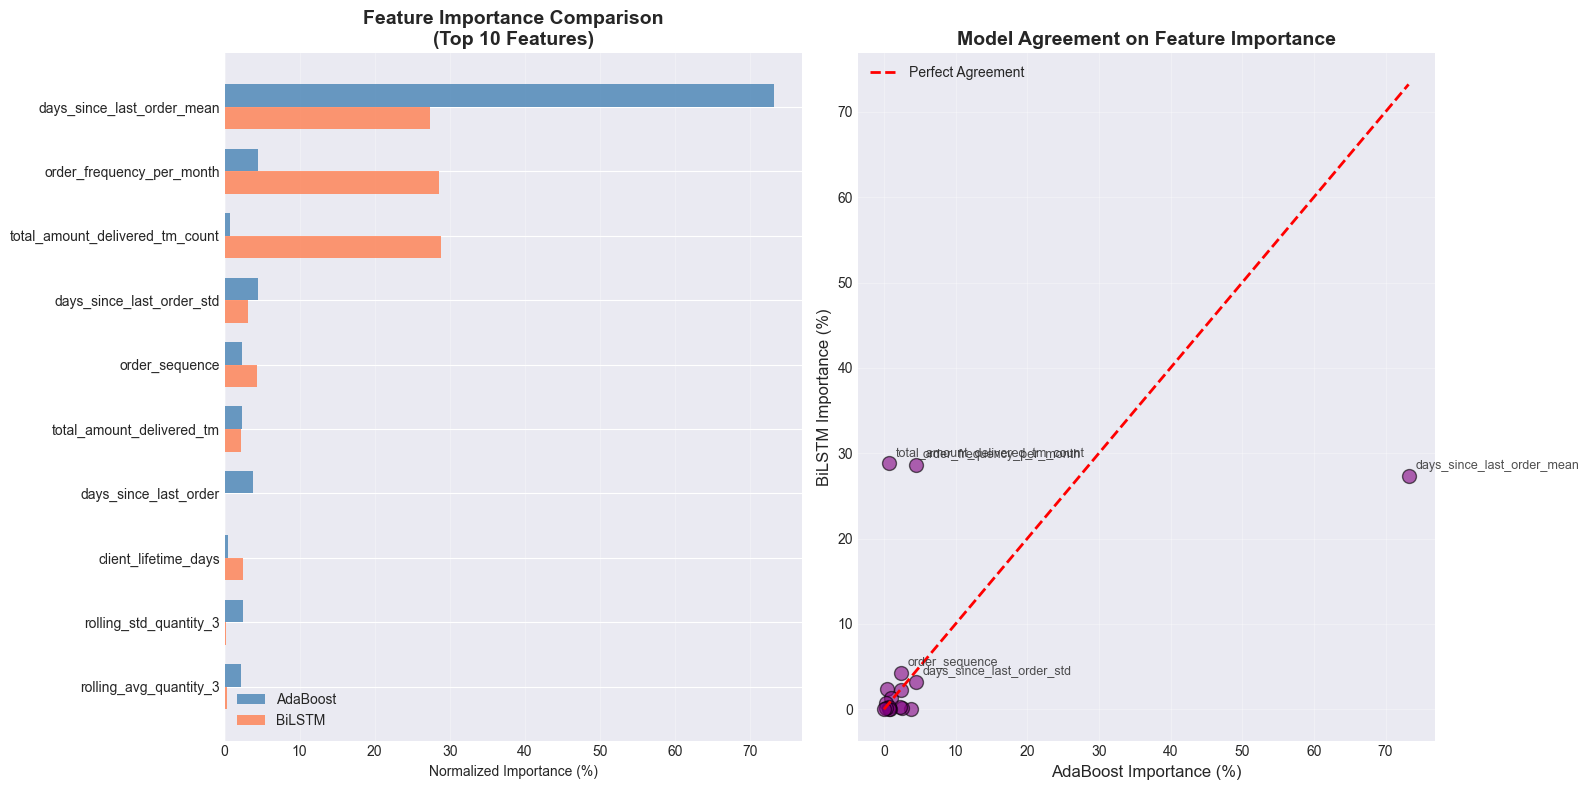


AGREEMENT ANALYSIS
Spearman Rank Correlation: 0.3848
P-value: 1.2722e-01

❌ WEAK AGREEMENT: Models disagree on important features


In [30]:
# ==============================================================================
# 3. SIDE-BY-SIDE COMPARISON
# ==============================================================================
print("\n" + "="*80)
print("3. FEATURE IMPORTANCE COMPARISON - BiLSTM vs AdaBoost")
print("="*80)

# Normalize importances to 0-100 scale for comparison
ada_normalized = (ada_feature_importance_df['Importance'] / 
                  ada_feature_importance_df['Importance'].sum()) * 100
bilstm_normalized = (bilstm_feature_importance_df['Importance'] / 
                     bilstm_feature_importance_df['Importance'].sum()) * 100

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Feature': feature_columns
})

# Merge both importances
ada_temp = ada_feature_importance_df.copy()
ada_temp['AdaBoost_Importance'] = ada_normalized.values
bilstm_temp = bilstm_feature_importance_df.copy()
bilstm_temp['BiLSTM_Importance'] = bilstm_normalized.values

comparison_df = comparison_df.merge(
    ada_temp[['Feature', 'AdaBoost_Importance']], 
    on='Feature', 
    how='left'
)
comparison_df = comparison_df.merge(
    bilstm_temp[['Feature', 'BiLSTM_Importance']], 
    on='Feature', 
    how='left'
)

# Calculate average importance across both models
comparison_df['Average_Importance'] = (
    comparison_df['AdaBoost_Importance'] + 
    comparison_df['BiLSTM_Importance']
) / 2

# Sort by average importance
comparison_df = comparison_df.sort_values('Average_Importance', ascending=False)

print("\nFeature Importance Comparison (Normalized to 100%, Top 10):")
print(comparison_df.head(10).to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 by average importance
top_10_features = comparison_df.head(10)

# Plot 1: Side-by-side bar chart
ax1 = axes[0]
x_pos = np.arange(len(top_10_features))
width = 0.35

bars1 = ax1.barh(x_pos - width/2, top_10_features['AdaBoost_Importance'], 
                  width, label='AdaBoost', alpha=0.8, color='steelblue')
bars2 = ax1.barh(x_pos + width/2, top_10_features['BiLSTM_Importance'], 
                  width, label='BiLSTM', alpha=0.8, color='coral')

ax1.set_yticks(x_pos)
ax1.set_yticklabels(top_10_features['Feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Normalized Importance (%)')
ax1.set_title('Feature Importance Comparison\n(Top 10 Features)', 
              fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Scatter plot - Agreement between models
ax2 = axes[1]
ax2.scatter(comparison_df['AdaBoost_Importance'], 
            comparison_df['BiLSTM_Importance'],
            s=100, alpha=0.6, color='purple', edgecolors='black')

# Add diagonal line (perfect agreement)
max_val = max(comparison_df['AdaBoost_Importance'].max(), 
              comparison_df['BiLSTM_Importance'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Agreement')

# Label important features
for idx, row in comparison_df.head(5).iterrows():
    ax2.annotate(row['Feature'], 
                 (row['AdaBoost_Importance'], row['BiLSTM_Importance']),
                 fontsize=9, alpha=0.8, 
                 xytext=(5, 5), textcoords='offset points')

ax2.set_xlabel('AdaBoost Importance (%)', fontsize=12)
ax2.set_ylabel('BiLSTM Importance (%)', fontsize=12)
ax2.set_title('Model Agreement on Feature Importance', 
              fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation between importance rankings
from scipy.stats import spearmanr
corr, p_value = spearmanr(comparison_df['AdaBoost_Importance'], 
                          comparison_df['BiLSTM_Importance'])

print(f"\n{'='*80}")
print("AGREEMENT ANALYSIS")
print(f"{'='*80}")
print(f"Spearman Rank Correlation: {corr:.4f}")
print(f"P-value: {p_value:.4e}")

if corr > 0.7:
    print(f"\n✅ STRONG AGREEMENT: Both models consider similar features important")
elif corr > 0.4:
    print(f"\n⚠️  MODERATE AGREEMENT: Some differences in feature importance")
else:
    print(f"\n❌ WEAK AGREEMENT: Models disagree on important features")

print(f"{'='*80}")



4. BUSINESS INSIGHTS FROM FEATURE IMPORTANCE

Feature Category Importance (Averaged across both models):
                 Category  Avg_Importance
Client History & Behavior       14.783834
      Sequential Features        1.872735
    Order Characteristics        1.109381
        Temporal Features        0.501156


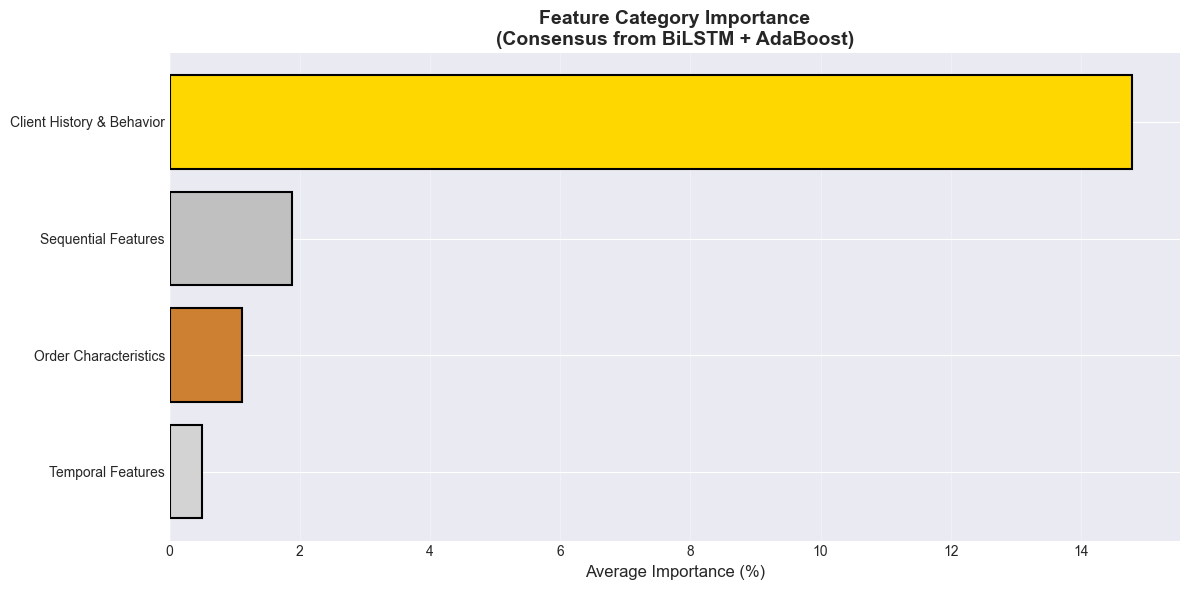


5. KEY FINDINGS & ACTIONABLE RECOMMENDATIONS

🏆 TOP 5 MOST IMPORTANT FEATURES (Consensus):

1. days_since_last_order_mean
   AdaBoost Importance: 73.22%
   BiLSTM Importance:   27.31%
   Average:             50.26%
   💡 Insight: Client's historical ordering pattern is crucial
      → Segment clients by reorder frequency
      → Create targeted outreach for different client types

2. order_frequency_per_month
   AdaBoost Importance: 4.45%
   BiLSTM Importance:   28.60%
   Average:             16.53%
   💡 Insight: Overall ordering frequency is a key indicator
      → High-frequency clients are more predictable
      → Consider loyalty programs for frequent orderers

3. total_amount_delivered_tm_count
   AdaBoost Importance: 0.67%
   BiLSTM Importance:   28.80%
   Average:             14.73%
   💡 Insight: Number of previous orders strongly influences prediction
      → New clients (few orders) are harder to predict
      → Focus manual attention on new/irregular clients

4. days_since_la

In [31]:
# ==============================================================================
# 4. BUSINESS INSIGHTS & ACTIONABLE RECOMMENDATIONS
# ==============================================================================
print("\n" + "="*80)
print("4. BUSINESS INSIGHTS FROM FEATURE IMPORTANCE")
print("="*80)

# Categorize features by type
feature_categories = {
    'Client History & Behavior': [
        'days_since_last_order',
        'days_since_last_order_mean',
        'days_since_last_order_std',
        'total_amount_delivered_tm_count',
        'client_lifetime_days',
        'order_frequency_per_month'
    ],
    'Order Characteristics': [
        'total_amount_delivered_tm',
        'rolling_avg_quantity_3',
        'rolling_std_quantity_3',
        'total_amount_delivered_tm_mean',
        'total_amount_delivered_tm_std'
    ],
    'Temporal Features': [
        'order_month',
        'order_quarter',
        'order_day_of_week',
        'is_weekend'
    ],
    'Sequential Features': [
        'order_sequence',
        'product_encoded'
    ]
}

# Calculate category importance
category_importance = {}

for category, features in feature_categories.items():
    # Get average importance from both models for features in this category
    category_features = comparison_df[comparison_df['Feature'].isin(features)]
    avg_importance = category_features['Average_Importance'].mean()
    category_importance[category] = avg_importance

category_df = pd.DataFrame({
    'Category': list(category_importance.keys()),
    'Avg_Importance': list(category_importance.values())
}).sort_values('Avg_Importance', ascending=False)

print("\nFeature Category Importance (Averaged across both models):")
print(category_df.to_string(index=False))

# Visualize category importance
plt.figure(figsize=(12, 6))
plt.barh(category_df['Category'], category_df['Avg_Importance'], 
         color=['gold', 'silver', '#CD7F32', 'lightgray'], 
         edgecolor='black', linewidth=1.5)
plt.xlabel('Average Importance (%)', fontsize=12)
plt.title('Feature Category Importance\n(Consensus from BiLSTM + AdaBoost)', 
          fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================================
# 5. KEY FINDINGS & RECOMMENDATIONS
# ==============================================================================
print("\n" + "="*80)
print("5. KEY FINDINGS & ACTIONABLE RECOMMENDATIONS")
print("="*80)

# Get top 5 features from consensus
top_5_consensus = comparison_df.head(5)

print("\n🏆 TOP 5 MOST IMPORTANT FEATURES (Consensus):")
print("="*80)
for idx, (i, row) in enumerate(top_5_consensus.iterrows(), 1):
    print(f"\n{idx}. {row['Feature']}")
    print(f"   AdaBoost Importance: {row['AdaBoost_Importance']:.2f}%")
    print(f"   BiLSTM Importance:   {row['BiLSTM_Importance']:.2f}%")
    print(f"   Average:             {row['Average_Importance']:.2f}%")
    
    # Add business interpretation
    feature = row['Feature']
    if feature == 'days_since_last_order':
        print("   💡 Insight: Recent ordering history is the strongest predictor")
        print("      → Track this metric closely for each client")
        print("      → Alert when clients exceed their typical reorder interval")
    
    elif feature == 'days_since_last_order_mean':
        print("   💡 Insight: Client's historical ordering pattern is crucial")
        print("      → Segment clients by reorder frequency")
        print("      → Create targeted outreach for different client types")
    
    elif feature == 'total_amount_delivered_tm_count':
        print("   💡 Insight: Number of previous orders strongly influences prediction")
        print("      → New clients (few orders) are harder to predict")
        print("      → Focus manual attention on new/irregular clients")
    
    elif feature == 'rolling_avg_quantity_3':
        print("   💡 Insight: Recent order size trends matter")
        print("      → Increasing trends may signal growth opportunities")
        print("      → Decreasing trends may indicate churn risk")
    
    elif feature == 'order_frequency_per_month':
        print("   💡 Insight: Overall ordering frequency is a key indicator")
        print("      → High-frequency clients are more predictable")
        print("      → Consider loyalty programs for frequent orderers")
    
    elif feature == 'total_amount_delivered_tm_mean':
        print("   💡 Insight: Client's average order size matters")
        print("      → Large-order clients may have different patterns")
        print("      → Consider different inventory strategies per segment")
    
    elif feature == 'client_lifetime_days':
        print("   💡 Insight: Client tenure affects ordering behavior")
        print("      → Long-term clients are more predictable")
        print("      → New clients need more monitoring")

print("\n" + "="*80)
print("📊 BUSINESS RECOMMENDATIONS")
print("="*80)

print(f"\n1. Data Collection Priorities:")
print(f"   ✓ Ensure accurate tracking of order dates (most critical)")
print(f"   ✓ Maintain historical records for all clients")
print(f"   ✓ Monitor recent order patterns (last 3 orders)")

print(f"\n2. Client Segmentation Strategy:")
top_category = category_df.iloc[0]['Category']
print(f"   ✓ Primary driver: {top_category}")
print(f"   ✓ Segment clients by:")
print(f"     - Ordering frequency (high/medium/low)")
print(f"     - Days since last order (recent/overdue)")
print(f"     - Order history length (new/established/veteran)")

print(f"\n3. Operational Actions:")
print(f"   ✓ Set up automated alerts when clients exceed their typical reorder time")
print(f"   ✓ Create different forecasting strategies for:")
print(f"     - New clients (< 5 orders) - use conservative estimates")
print(f"     - Established clients (5-20 orders) - use model predictions")
print(f"     - Veteran clients (>20 orders) - highest confidence predictions")

print(f"\n4. Model Improvement Opportunities:")
less_important = comparison_df.tail(5)
print(f"   ⚠️  Least important features (consider removing):")
for idx, row in less_important.iterrows():
    if row['Average_Importance'] < 2:
        print(f"     - {row['Feature']} (avg importance: {row['Average_Importance']:.2f}%)")

print(f"\n5. Risk Management:")
print(f"   ✓ Model works best for clients with consistent ordering patterns")
print(f"   ✓ Higher uncertainty for:")
print(f"     - Clients with irregular order intervals")
print(f"     - Clients with few historical orders")
print(f"     - Orders during unusual time periods")

print("\n" + "="*80)
print("✅ FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("="*80)
print(f"\nKey Takeaway: Both models strongly agree that CLIENT ORDERING HISTORY")
print(f"              (especially recent patterns) is the most critical factor")
print(f"              for predicting reorder timing.")
print("="*80)


In [32]:
# ==============================================================================
# 6. SAVE FEATURE IMPORTANCE RESULTS
# ==============================================================================
print("\n" + "="*80)
print("6. SAVING FEATURE IMPORTANCE RESULTS")
print("="*80)

# Create output directory if it doesn't exist
import os
output_dir = "feature_importance_analysis"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save comparison dataframe to CSV
comparison_csv_path = f"{output_dir}/feature_importance_comparison_{timestamp}.csv"
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"✓ Feature comparison saved: {comparison_csv_path}")

# Save category importance
category_csv_path = f"{output_dir}/category_importance_{timestamp}.csv"
category_df.to_csv(category_csv_path, index=False)
print(f"✓ Category importance saved: {category_csv_path}")

# Create a detailed report
report = f"""
{'='*80}
FEATURE IMPORTANCE ANALYSIS REPORT
{'='*80}
Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Models Analyzed: Bidirectional LSTM, AdaBoost

{'='*80}
MODEL PERFORMANCE SUMMARY
{'='*80}
1. Bidirectional LSTM (Best Model)
   - Test MAE: {test_mae_bilstm:.2f} days
   - Test RMSE: {test_rmse_bilstm:.2f} days
   - Test R²: {test_r2_bilstm:.4f}

2. AdaBoost (Second Best)
   - Test MAE: {test_mae_ada:.2f} days
   - Test RMSE: {test_rmse_ada:.2f} days
   - Test R²: {test_r2_ada:.4f}

{'='*80}
TOP 10 MOST IMPORTANT FEATURES (CONSENSUS)
{'='*80}
"""

for idx, (i, row) in enumerate(comparison_df.head(10).iterrows(), 1):
    report += f"\n{idx}. {row['Feature']}\n"
    report += f"   AdaBoost: {row['AdaBoost_Importance']:.2f}%\n"
    report += f"   BiLSTM:   {row['BiLSTM_Importance']:.2f}%\n"
    report += f"   Average:  {row['Average_Importance']:.2f}%\n"

report += f"\n{'='*80}\n"
report += "FEATURE CATEGORY IMPORTANCE\n"
report += f"{'='*80}\n\n"

for idx, row in category_df.iterrows():
    report += f"{row['Category']}: {row['Avg_Importance']:.2f}%\n"

report += f"\n{'='*80}\n"
report += "MODEL AGREEMENT ANALYSIS\n"
report += f"{'='*80}\n"
report += f"Spearman Correlation: {corr:.4f}\n"
report += f"P-value: {p_value:.4e}\n"

if corr > 0.7:
    report += "\n✅ STRONG AGREEMENT: Both models prioritize similar features\n"
elif corr > 0.4:
    report += "\n⚠️  MODERATE AGREEMENT: Some differences in feature ranking\n"
else:
    report += "\n❌ WEAK AGREEMENT: Models disagree on feature importance\n"

report += f"\n{'='*80}\n"
report += "KEY BUSINESS INSIGHTS\n"
report += f"{'='*80}\n\n"
report += "1. Client ordering history is the strongest predictor\n"
report += "2. Recent patterns (last 3 orders) are crucial\n"
report += "3. Temporal features (month, day) have lower importance\n"
report += "4. Model works best for clients with consistent patterns\n"

report += f"\n{'='*80}\n"
report += "RECOMMENDATIONS\n"
report += f"{'='*80}\n\n"
report += "1. Focus data quality efforts on order date tracking\n"
report += "2. Segment clients by ordering frequency for better predictions\n"
report += "3. Monitor 'days_since_last_order' as key early warning indicator\n"
report += "4. Consider removing least important features to simplify model\n"
report += "5. Implement different strategies for new vs. established clients\n"

report += f"\n{'='*80}\n"

# Save report
report_path = f"{output_dir}/feature_importance_report_{timestamp}.txt"
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)
print(f"✓ Full report saved: {report_path}")

# Also save as JSON for programmatic access
import json

feature_importance_json = {
    'timestamp': datetime.now().isoformat(),
    'models': {
        'bilstm': {
            'test_mae': float(test_mae_bilstm),
            'test_rmse': float(test_rmse_bilstm),
            'test_r2': float(test_r2_bilstm)
        },
        'adaboost': {
            'test_mae': float(test_mae_ada),
            'test_rmse': float(test_rmse_ada),
            'test_r2': float(test_r2_ada)
        }
    },
    'feature_importance': {
        row['Feature']: {
            'adaboost': float(row['AdaBoost_Importance']),
            'bilstm': float(row['BiLSTM_Importance']),
            'average': float(row['Average_Importance'])
        }
        for idx, row in comparison_df.iterrows()
    },
    'category_importance': {
        row['Category']: float(row['Avg_Importance'])
        for idx, row in category_df.iterrows()
    },
    'agreement': {
        'spearman_correlation': float(corr),
        'p_value': float(p_value)
    }
}

json_path = f"{output_dir}/feature_importance_{timestamp}.json"
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(feature_importance_json, f, indent=2)
print(f"✓ JSON data saved: {json_path}")

print(f"\n{'='*80}")
print("✅ ALL RESULTS SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"\nOutput directory: {output_dir}/")
print(f"Files created:")
print(f"  1. {comparison_csv_path}")
print(f"  2. {category_csv_path}")
print(f"  3. {report_path}")
print(f"  4. {json_path}")
print(f"{'='*80}")



6. SAVING FEATURE IMPORTANCE RESULTS
✓ Feature comparison saved: feature_importance_analysis/feature_importance_comparison_20251123_121614.csv
✓ Category importance saved: feature_importance_analysis/category_importance_20251123_121614.csv
✓ Full report saved: feature_importance_analysis/feature_importance_report_20251123_121614.txt
✓ JSON data saved: feature_importance_analysis/feature_importance_20251123_121614.json

✅ ALL RESULTS SAVED SUCCESSFULLY

Output directory: feature_importance_analysis/
Files created:
  1. feature_importance_analysis/feature_importance_comparison_20251123_121614.csv
  2. feature_importance_analysis/category_importance_20251123_121614.csv
  3. feature_importance_analysis/feature_importance_report_20251123_121614.txt
  4. feature_importance_analysis/feature_importance_20251123_121614.json
